In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.tree as tree
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

seed = 42

In [26]:
data_raw_full = pd.read_excel('nshap_w1_w2_w3_core_disposition.xls')
data_raw_full.drop(columns=["A2. Diabetic Glycosylated Hemoglobin",
                            "B5. Systolic Blood Pressure",
                            "B6. Diastolic Blood Pressure",
                            "B7. Rapid Pulse",
                            "G20. Central Obesity",
                            "G21. Obese",
                            "H22. Atypical Sleep",
                            "H23. Wakes Up Tired",
                            "I25. Heavy Drinker",
                            "I26. Smoker",
                            "J28. Perceived Stress",
                            "J30. Loneliness",
                            "J32. Low Self-Esteem",
                            "J33. Unhappiness",
                            "K34. Cognition",
                            "L35. Taste Identification",
                            "L36. Visual Acuity (Tested)",
                            "L37. Night Vision",
                            "L38. Sense of Touch Threshold",
                            "L39. Odor Identification",
                            "L40. Interviewer-Rated Hearing",
                            "M42. Chronic Inflammation",
                            "N47. Bone Fracture since Age 45",
                            "N48. Osteoporotic Fracture",
                            "N50. Difficulty with Activities of Daily Living",
                            "S68. Perceived Isolation"
                            ],
                   inplace=True)


In [27]:
data_raw_full

respondent id  W3 sample type  W3 Recode of Final Disposition  \
0          10000050             1.0                             1.0   
1          10000060             1.0                             2.0   
2          10000070             1.0                             2.0   
3          10000080             1.0                             1.0   
4          10000090             1.0                             1.0   
...             ...             ...                             ...   
3000       10043500             NaN                             NaN   
3001       10043600             NaN                             NaN   
3002       10043690             NaN                             NaN   
3003       10043810             NaN                             NaN   
3004       10043930             NaN                             NaN   

      W3 Deceased  W2 Recode of Final Disposition  W2 Deceased  \
0             0.0                               1          0.0   
1             1.0                               1          0.0   
2             1.0                               1          0.0   
3             0.0                               5          0.0   
4             0.0                               1          0.0   
...           ...                             ...          ...   
3000          NaN                               2          1.0   
3001          NaN                               2          1.0   
3002          NaN                               2          1.0   
3003          NaN                               2          1.0   
3004          NaN                               2          1.0   

      person-level weight (nonresponse adjusted)  (pseudo) sampling stratum  \
0                                       1.151978                         56   
1                                       0.649874                         56   
2                                       0.639700                         21   
3                                       1.193744                         15   
4                                       0.299111                         31   
...                                          ...                        ...   
3000                                    0.649874                         50   
3001                                    0.401704                         42   
3002                                    0.674039                          2   
3003                                    0.689935                          2   
3004                                    0.987789                         47   

      (pseudo) psu  Final Social Comprehensive Classes  ...  \
0              562                                   1  ...   
1              562                                   5  ...   
2              211                                   1  ...   
3              152                                   4  ...   
4              311                                   4  ...   
...            ...                                 ...  ...   
3000           502                                   4  ...   
3001           422                                   5  ...   
3002            22                                   6  ...   
3003            21                                   2  ...   
3004           471                                   3  ...   

      R66. High Social Strain  S67. Lack of Network Diversity  \
0                         0.0                               1   
1                         0.0                               0   
2                         0.0                               0   
3                         0.0                               1   
4                         1.0                               0   
...                       ...                             ...   
3000                      NaN                               1   
3001                      0.0                               1   
3002                      0.0                               1   
3003

In [28]:
# W2 > 3, 但W3可以确定，应该保留
data_raw_full.drop(index=data_raw_full[data_raw_full['W3 Recode of Final Disposition'] > 3].index, inplace=True)
data_raw_full.drop(index=data_raw_full[data_raw_full['W2 Recode of Final Disposition'] > 3].index, inplace=True)

data_raw_full['Label'] = (data_raw_full['W3 Recode of Final Disposition'] > 1) | (
            data_raw_full['W2 Recode of Final Disposition'] > 1)
data_raw_full['Label'] = data_raw_full['Label'].apply(int)
data_raw_full['Label'].sum()

1120

In [29]:
len(data_raw_full)

2682

In [30]:
(data_raw_full['W3 Recode of Final Disposition'] == 1).sum()

1554

In [40]:
# Multiple-Impute 优化一下
# Algorithm deal with missing
imp = SimpleImputer(strategy='most_frequent')
data_filled = imp.fit_transform(data_raw_full)
data_filled = pd.DataFrame(data_filled, columns=data_raw_full.columns)
data_filled

respondent id  W3 sample type  W3 Recode of Final Disposition  \
0        10000050.0             1.0                             1.0   
1        10000060.0             1.0                             2.0   
2        10000070.0             1.0                             2.0   
3        10000090.0             1.0                             1.0   
4        10000100.0             1.0                             1.0   
...             ...             ...                             ...   
2677     10043500.0             1.0                             1.0   
2678     10043600.0             1.0                             1.0   
2679     10043690.0             1.0                             1.0   
2680     10043810.0             1.0                             1.0   
2681     10043930.0             1.0                             1.0   

      W3 Deceased  W2 Recode of Final Disposition  W2 Deceased  \
0             0.0                             1.0          0.0   
1             1.0                             1.0          0.0   
2             1.0                             1.0          0.0   
3             0.0                             1.0          0.0   
4             0.0                             1.0          0.0   
...           ...                             ...          ...   
2677          0.0                             2.0          1.0   
2678          0.0                             2.0          1.0   
2679          0.0                             2.0          1.0   
2680          0.0                             2.0          1.0   
2681          0.0                             2.0          1.0   

      person-level weight (nonresponse adjusted)  (pseudo) sampling stratum  \
0                                       1.151978                       56.0   
1                                       0.649874                       56.0   
2                                       0.639700                       21.0   
3                                       0.299111                       31.0   
4                                       0.347846                       36.0   
...                                          ...                        ...   
2677                                    0.649874                       50.0   
2678                                    0.401704                       42.0   
2679                                    0.674039                        2.0   
2680                                    0.689935                        2.0   
2681                                    0.987789                       47.0   

      (pseudo) psu  Final Social Comprehensive Classes  ...  \
0            562.0                                 1.0  ...   
1            562.0                                 5.0  ...   
2            211.0                                 1.0  ...   
3            311.0                                 4.0  ...   
4            361.0                                 2.0  ...   
...            ...                                 ...  ...   
2677         502.0                                 4.0  ...   
2678         422.0                                 5.0  ...   
2679          22.0                                 6.0  ...   
2680          21.0                                 2.0  ...   
2681         471.0                                 3.0  ...   

      S67. Lack of Network Diversity  S69. Low Social Participation  \
0                                1.0                            0.0   
1                                0.0                            0.0   
2                                0.0                            0.0   
3                                0.0                            0.0   
4                                1.0                            0.0   
...                              ...                            ...   
2677                             1.0                            0.0   
2678                             1.0                            1.0   
2679           

In [41]:
data_filled["Weight"] = data_filled["person-level weight (nonresponse adjusted)"]
#data_filled["Weight_adj"] = data_filled["person-level weight (nonresponse adjusted)"] * data_filled[
#    "(pseudo) sampling stratum"]

data_filled.drop(columns=["respondent id",
                          "W3 sample type",
                          "W3 Recode of Final Disposition",
                          "W3 Deceased",
                          "W2 Recode of Final Disposition",
                          "W2 Deceased",
                          "person-level weight (nonresponse adjusted)",
                          "(pseudo) sampling stratum",
                          "(pseudo) psu",
                          "Final Social Comprehensive Classes",
                          "Comprehensive Health Classes",
                          "Medical Model Classes",
                          "self-rated mental health",
                          "self-rated physical health"
                          ], inplace=True)

In [42]:
data_filled
# 1 interviewed
# 2 deceased
# 3 too sick to interview
# 4 5 6 delete

# person-level, sampling weight (nshap over sample black, hispanic, blabla)
# sampling stratum
# primary sampling unit (psu, person-level)

A1. Diabetes  A3. Thyroid  A2_T1. Diabetic Glycosylated Hemoglobin  \
0              0.0          1.0                                      0.0   
1              0.0          0.0                                      0.0   
2              0.0          0.0                                      0.0   
3              0.0          0.0                                      0.0   
4              0.0          0.0                                      0.0   
...            ...          ...                                      ...   
2677           0.0          0.0                                      0.0   
2678           1.0          0.0                                      0.0   
2679           0.0          0.0                                      0.0   
2680           0.0          1.0                                      0.0   
2681           0.0          1.0                                      0.0   

      B4. Hypertension  B8. Heart Attack  B9. Cerebrovascular Disease  \
0                  0.0               0.0                          0.0   
1                  1.0               0.0                          0.0   
2                  0.0               0.0                          0.0   
3                  0.0               0.0                          0.0   
4                  1.0               0.0                          0.0   
...                ...               ...                          ...   
2677               0.0               0.0                          1.0   
2678               1.0               0.0                          0.0   
2679               0.0               0.0                          0.0   
2680               1.0               0.0                          0.0   
2681               1.0               0.0                          0.0   

      B10. Heart Failure  BT_T2. Systolic Blood Pressure  \
0                    0.0                             1.0   
1                    0.0                             1.0   
2                    0.0                             1.0   
3                    1.0                             0.0   
4                    0.0                             0.0   
...                  ...                             ...   
2677                 0.0                             1.0   
2678                 0.0                             1.0   
2679                 0.0                             0.0   
2680                 0.0                             0.0   
2681                 0.0                             0.0   

      B6_T2. Diastolic Blood Pressure  B7_T1. Rapid Pulse  ...  \
0                                 1.0                 1.0  ...   
1                                 0.0                 0.0  ...   
2                                 0.0                 1.0  ...   
3                                 0.0                 1.0  ...   
4                                 0.0                 1.0  ...   
...                               ...                 ...  ...   
2677                              0.0                 0.0  ...   
2678                              0.0                 0.0  ...   
2679                              0.0                 0.0  ...   
2680                              0.0                 0.0  ...   
2681                              1.0                 0.0  ...   

      R66. High Social Strain  S67. Lack of Network Diversity  \
0                         0.0                             1.0   
1                         0.0                             0.0   
2                         0.0                             0.0   
3                         1.0                             0.0   
4                         0.0                             1.0   
...                       ...                             ...   
2677                      0.0                             1.0   
2678                      0.0                             1.0   
2679                      0.0                             1.0   
2680                      0.0                       

## Decision Tree

In [43]:
data_nona = data_filled.copy()
seed = 42
data_nona.drop(columns=[
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)


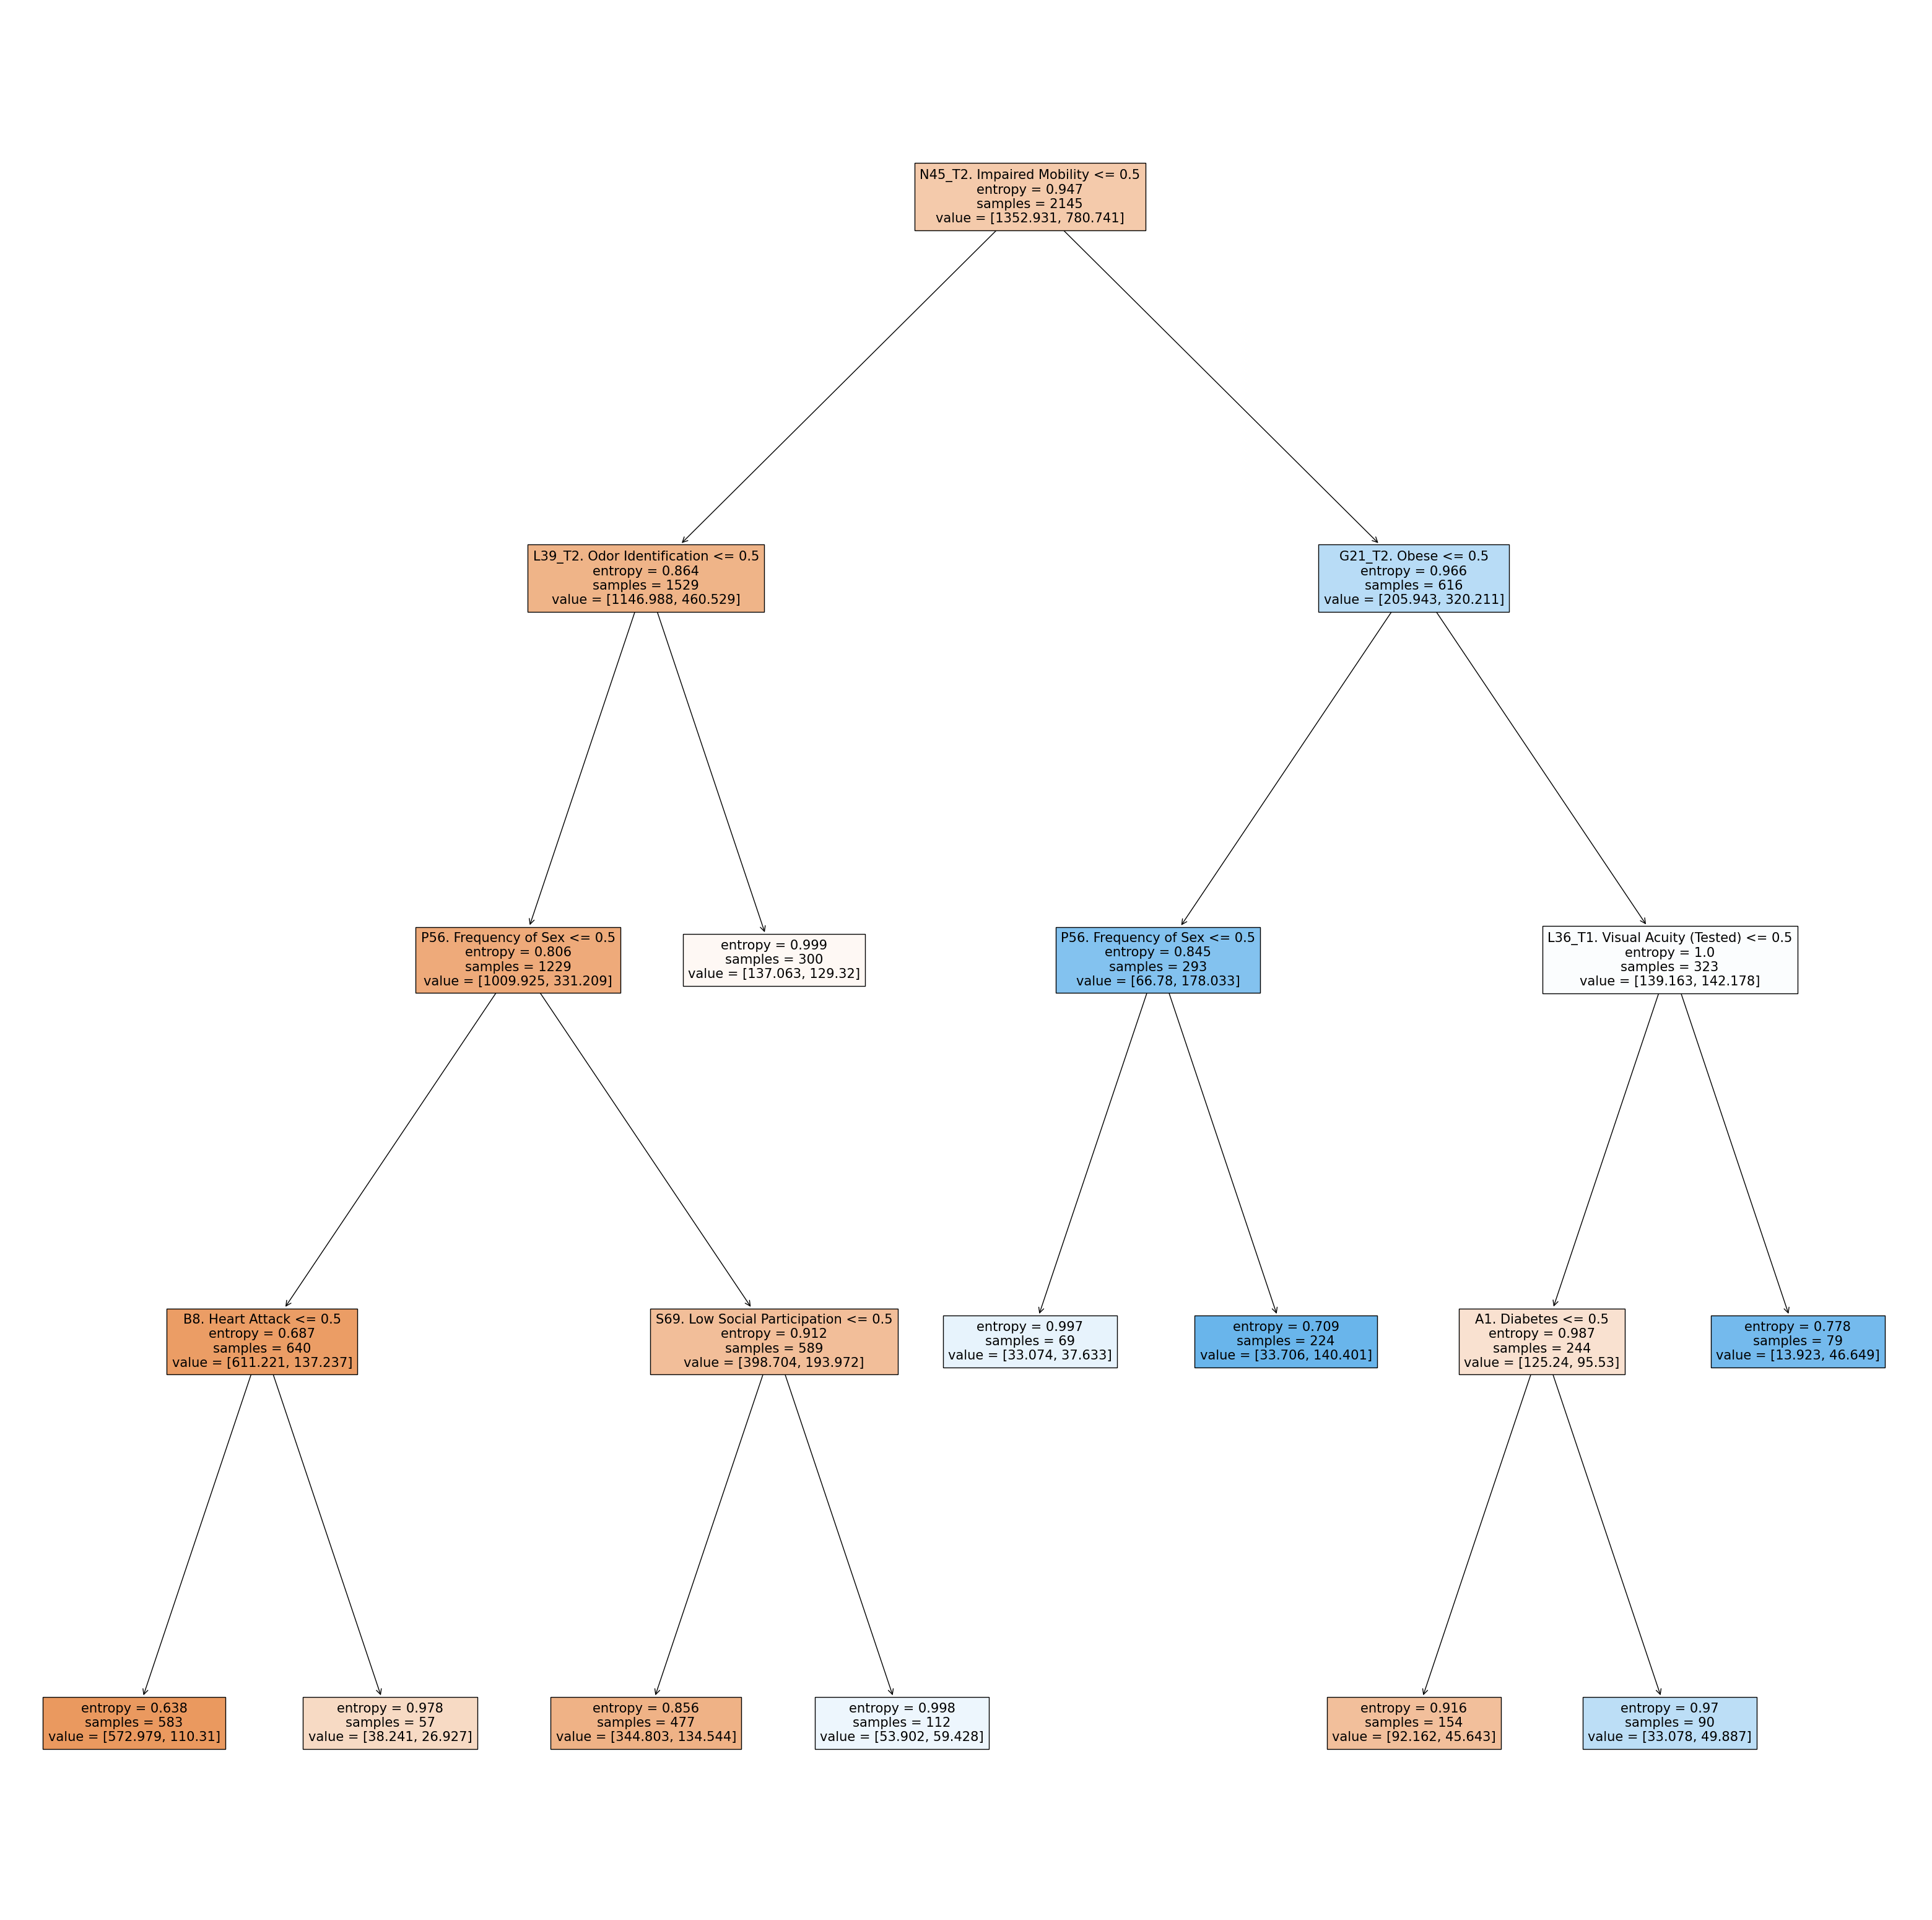

Performence on train set 0.7120330679506641
Performence on test set 0.6766967734592807
              precision    recall  f1-score   support

         0.0       0.69      0.85      0.76 334.7975964695215
         1.0       0.63      0.41      0.50 213.9978836029768

    accuracy                           0.68 548.7954800724983
   macro avg       0.66      0.63      0.63 548.7954800724983
weighted avg       0.67      0.68      0.66 548.7954800724983



'print("Performence on train set",\n      metrics.accuracy_score(DT_clf.predict(X_train), y_train))\ny_pred = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])\n\nprint("Performence on test set", metrics.accuracy_score(y_pred, y_test))\n\nprint(metrics.classification_report(y_test, y_pred))'

In [44]:
# 4到5层的树
# 把3放进去试试

#The re-weighted sample basing on statistics can better reflect the universal distribution, so we rised the min-impurity-decrease to 0.01. And do the same logic to train and evaluate.
DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.005)

DT_clf.fit(X_train.drop(columns='Weight', inplace=False), y_train, sample_weight=X_train['Weight'])
#DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.savefig('./tree.jpg')
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='Weight', inplace=False)), y_train,
                             sample_weight=X_train['Weight']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='Weight', inplace=False)), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['Weight']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['Weight']))

'''print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])

print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))'''

control age race(ethnicity) gender education
age->age group
casual tree
特征不重复

variable重新整理一下，weight&self-rated** ；
三张图：all，gender difference，social feature ；

## Gender Difference

1115


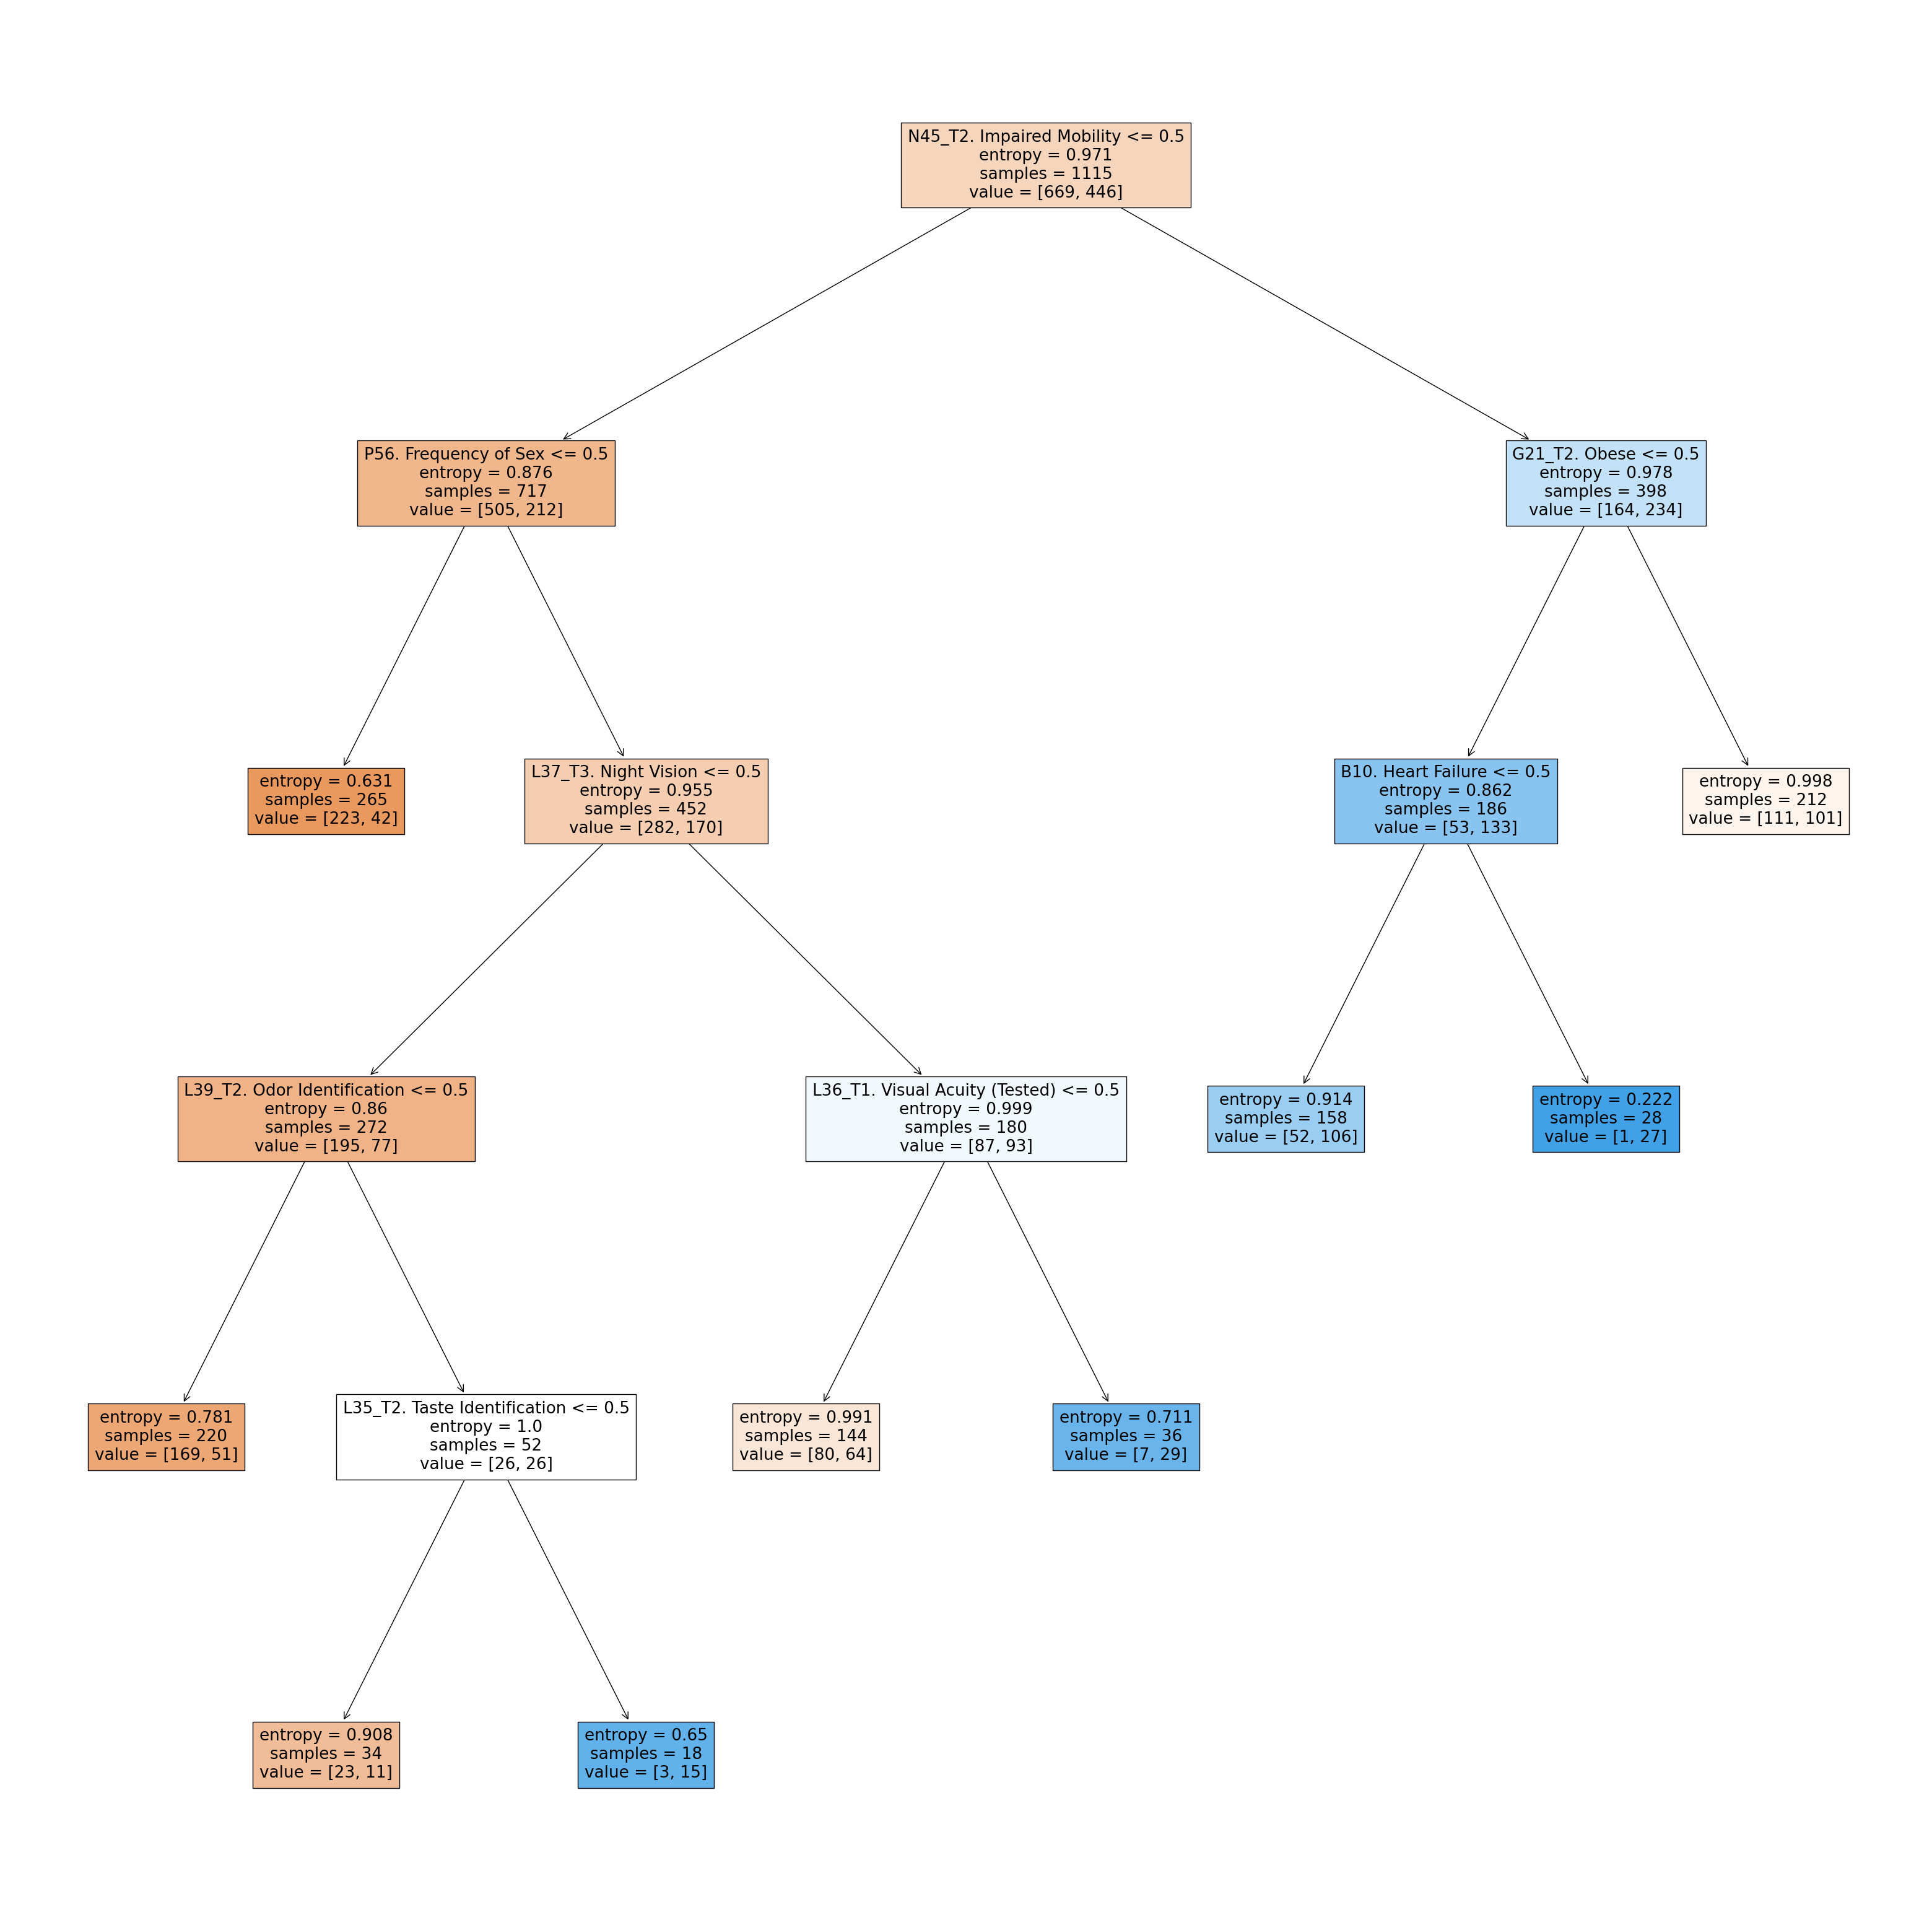

Performence on train set 0.7022421524663677
Performence on test set 0.6917562724014337
              precision    recall  f1-score   support

         0.0       0.68      0.90      0.78       168
         1.0       0.72      0.37      0.49       111

    accuracy                           0.69       279
   macro avg       0.70      0.64      0.63       279
weighted avg       0.70      0.69      0.66       279



In [46]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["gender of respondent"] == 2]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.008)
DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))

In [56]:
#Select the false case basing on mismatch between y_pred and labels
y_pred_dt = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])
y_prob_dt = pd.DataFrame(DT_clf.predict_proba(X_test)[:, 1], columns=["Label"])
X_wrong_dt = X_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
y_wrong_dt = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
dt_wrong = pd.concat([y_wrong_dt, X_wrong_dt], axis=1)
dt_wrong

Label  A1. Diabetes  A3. Thyroid  \
4      1.0           0.0          0.0   
8      1.0           1.0          1.0   
9      1.0           0.0          0.0   
10     1.0           0.0          0.0   
18     0.0           1.0          1.0   
..     ...           ...          ...   
267    1.0           0.0          0.0   
268    1.0           0.0          0.0   
271    1.0           1.0          0.0   
273    1.0           0.0          0.0   
274    1.0           0.0          0.0   

     A2_T1. Diabetic Glycosylated Hemoglobin  B4. Hypertension  \
4                                        0.0               1.0   
8                                        1.0               1.0   
9                                        0.0               1.0   
10                                       0.0               0.0   
18                                       0.0               0.0   
..                                       ...               ...   
267                                      0.0               1.0   
268                                      0.0               1.0   
271                                      1.0               1.0   
273                                      0.0               1.0   
274                                      0.0               1.0   

     B8. Heart Attack  B9. Cerebrovascular Disease  B10. Heart Failure  \
4                 0.0                          0.0                 0.0   
8                 1.0                          0.0                 0.0   
9                 0.0                          1.0                 1.0   
10                0.0                          0.0                 0.0   
18                0.0                          0.0                 0.0   
..                ...                          ...                 ...   
267               0.0                          0.0                 0.0   
268               0.0                          0.0                 0.0   
271               1.0                          0.0                 0.0   
273               0.0                          0.0                 1.0   
274               0.0                          0.0                 0.0   

     BT_T2. Systolic Blood Pressure  B6_T2. Diastolic Blood Pressure  ...  \
4                               0.0                              0.0  ...   
8                               1.0                              1.0  ...   
9                               0.0                              0.0  ...   
10                              0.0                              0.0  ...   
18                              1.0                              0.0  ...   
..                              ...                              ...  ...   
267                             0.0                              0.0  ...   
268                             1.0                              0.0  ...   
271                             0.0                              0.0  ...   
273                             0.0                              0.0  ...   
274                             0.0                              0.0  ...   

     Q60. Low DHEA  R63. Unmarried/Unpartnered  R64. Limited Network Size  \
4              0.0                         0.0                        0.0   
8              0.0                         1.0                        1.0   
9              0.0                         1.0                        0.0   
10             0.0                         1.0                        1.0   
18             0.0                         1.0                        0.0   
..             ...                         ...                        ...   
267            0.0                         1.0                        0.0   
268            0.0                         1.0                        0.0   
271            0.0                         0.0                        0.0   
273            0.0                         0.0                        0.0   
274            0.0                         1.0            

In [58]:
ftr_names

['A1. Diabetes',
 'A3. Thyroid',
 'A2_T1. Diabetic Glycosylated Hemoglobin',
 'B4. Hypertension',
 'B8. Heart Attack',
 'B9. Cerebrovascular Disease',
 'B10. Heart Failure',
 'BT_T2. Systolic Blood Pressure',
 'B6_T2. Diastolic Blood Pressure',
 'B7_T1. Rapid Pulse',
 'C11. COPD',
 'C12. Asthma',
 'D13. Arthritis',
 'D14. Peptic Ulcer',
 'E15. Chronic Kidney Disease',
 'E16. Cirrhosis or Severe Liver Damage',
 'F17. Skin Cancer',
 'F18. Reproductive Cancer',
 'F19. Non-Reproductive Cancer',
 'G20_T1. Central Obesity',
 'G21_T2. Obese',
 'H22_T2. Atypical Sleep',
 'H23_T2. Wakes Up Tired',
 'I24. Drinking Problem',
 'I27. STDs',
 'I25_T1. Heavy Drinker',
 'I26_T2. Smoker',
 'J29. Depressive Symptoms',
 'J31. Anxiety Symptoms',
 'J28_T3. Perceived Stress',
 'J30_T2. Loneliness',
 'J32_T1. Low Self-Esteem',
 'J33_T1. Unhappiness',
 'K34_T3. Cognition',
 'L35_T2. Taste Identification',
 'L36_T1. Visual Acuity (Tested)',
 'L37_T3. Night Vision',
 'L38_T2. Sense of Touch Threshold',
 'L39_T2

1030


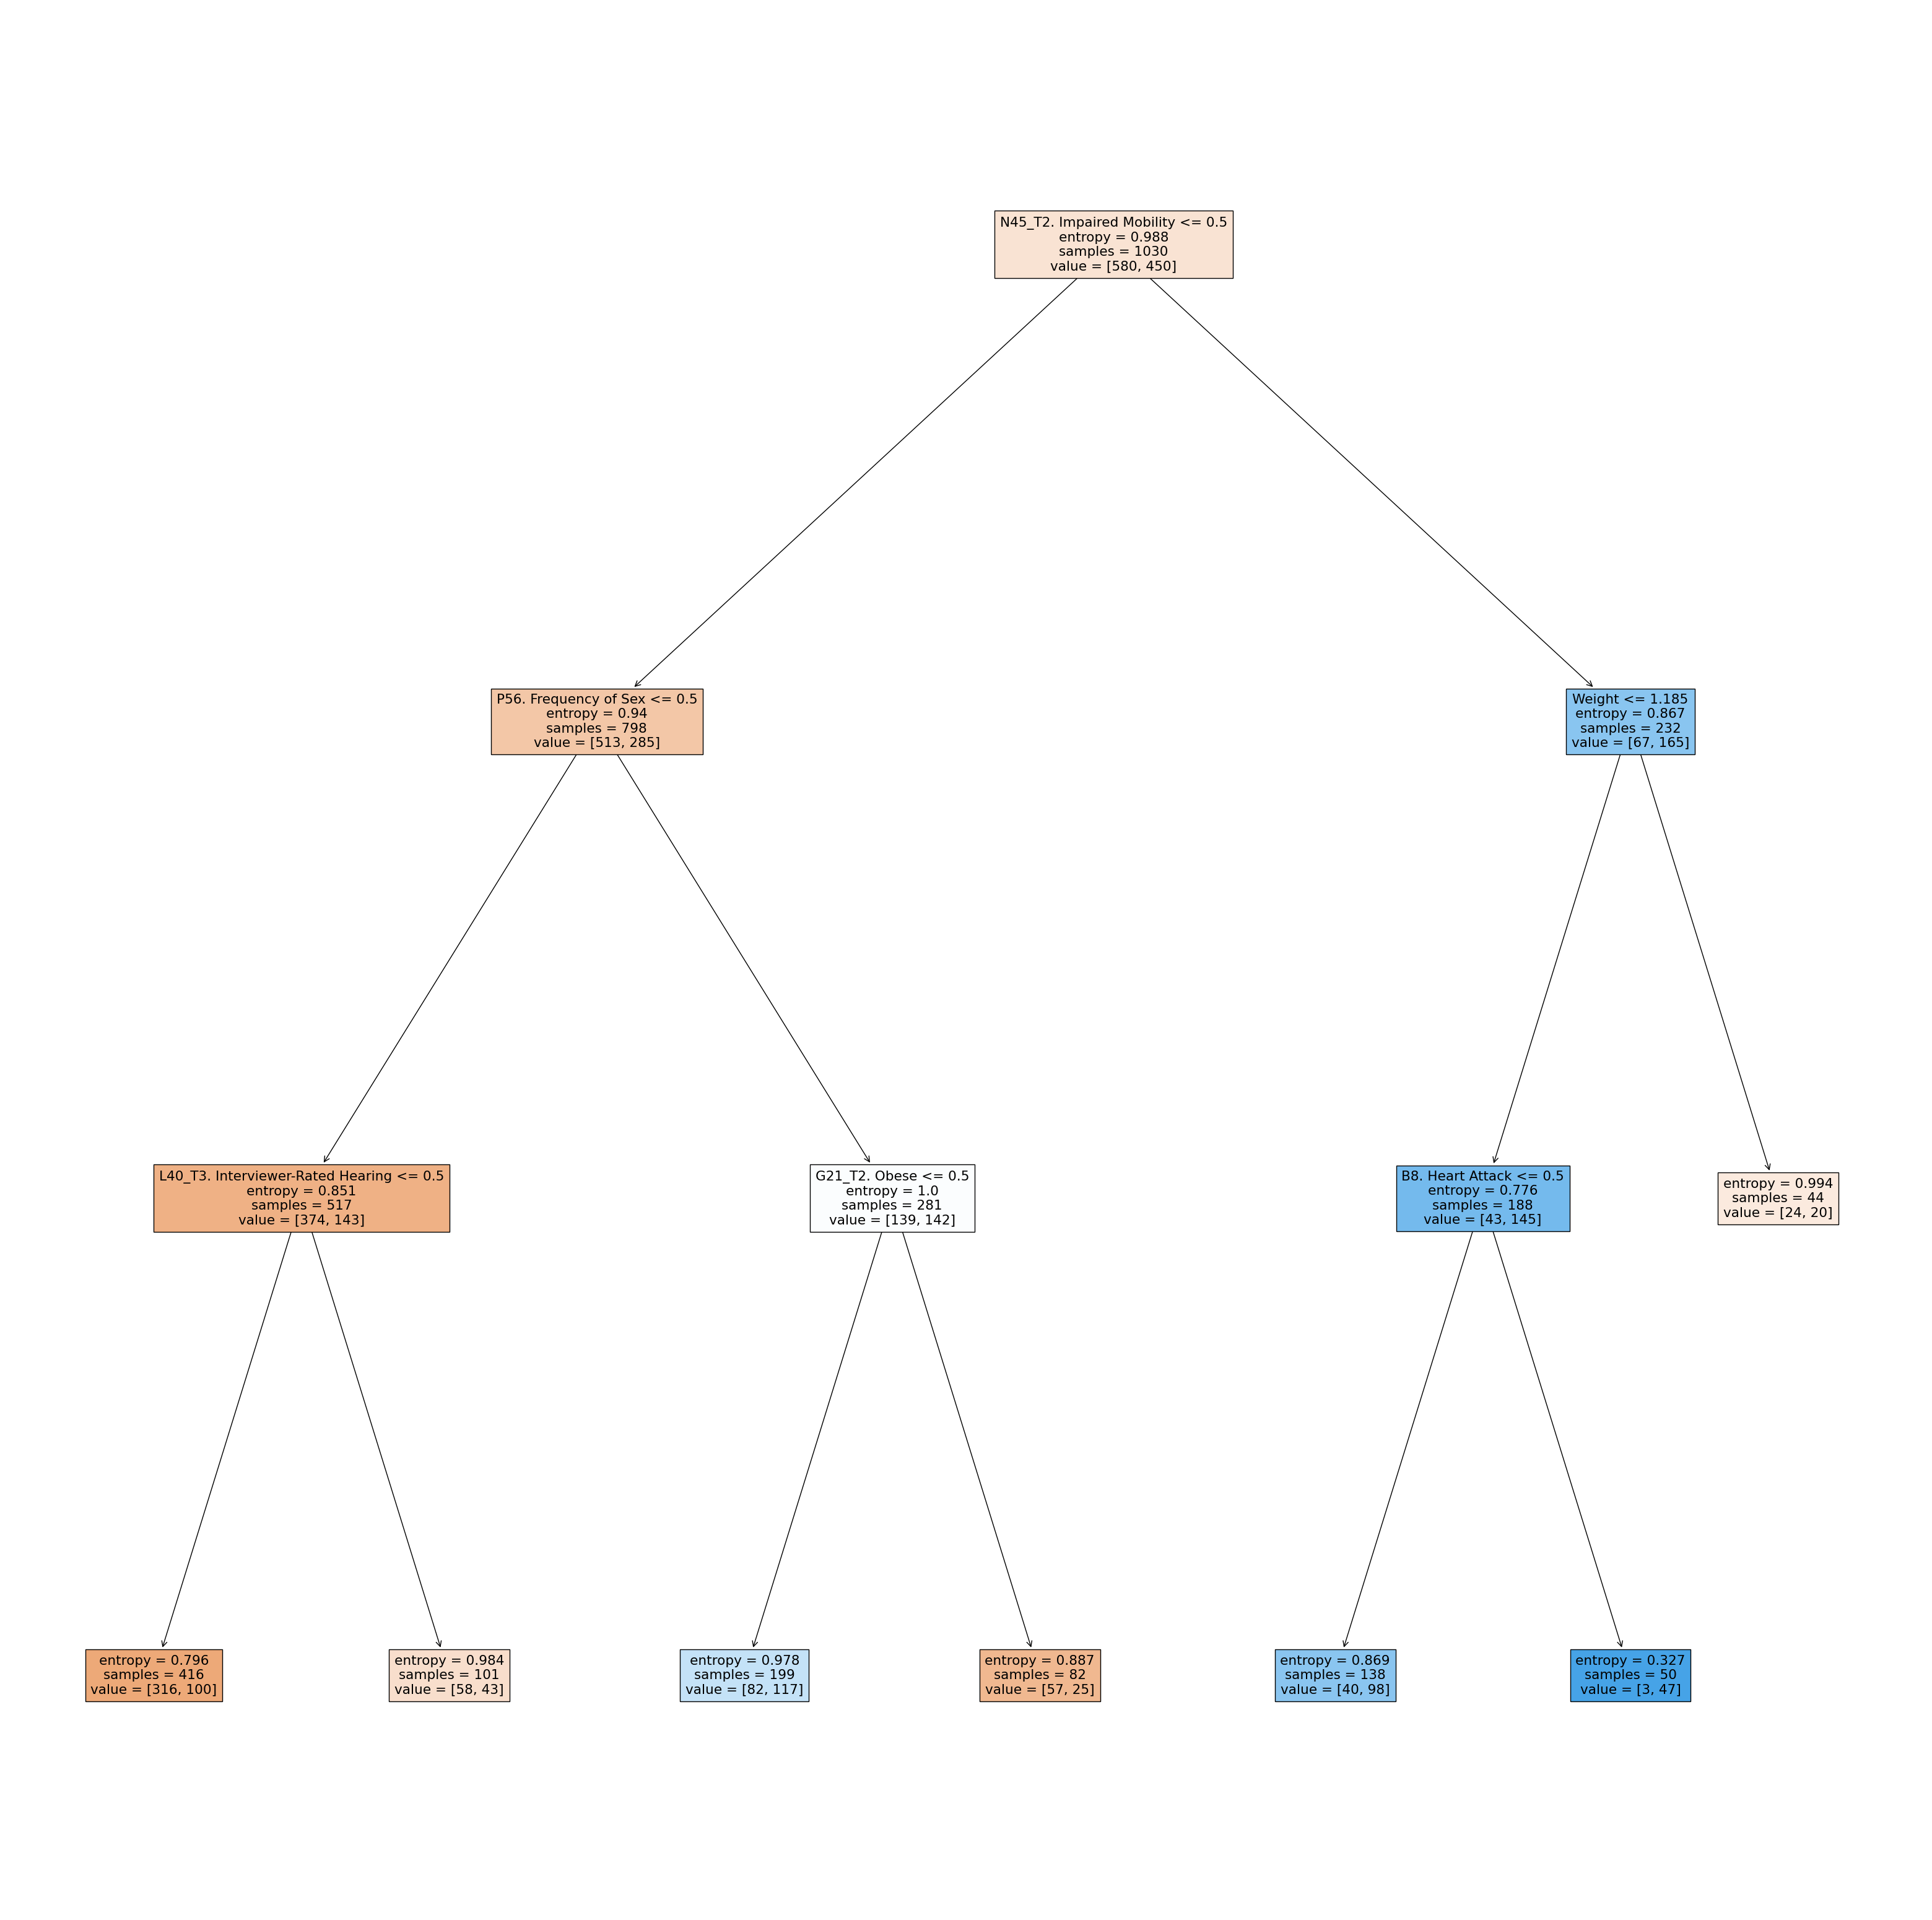

Performence on train set 0.6961165048543689
Performence on test set 0.624031007751938
              precision    recall  f1-score   support

         0.0       0.65      0.73      0.69       145
         1.0       0.59      0.49      0.53       113

    accuracy                           0.62       258
   macro avg       0.62      0.61      0.61       258
weighted avg       0.62      0.62      0.62       258



In [47]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["gender of respondent"] == 1]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.008)
DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))

In [100]:
#Select the false case basing on mismatch between y_pred and labels
y_pred_dt = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])
y_prob_dt = pd.DataFrame(DT_clf.predict_proba(X_test)[:, 1], columns=["Label"])
X_wrong_dt = X_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
y_wrong_dt = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['Label'] != y_test.reset_index(inplace=False)['Label']
    ]
dt_wrong = pd.concat([y_wrong_dt, X_wrong_dt], axis=1)
dt_wrong

Label  A1. Diabetes  A3. Thyroid  \
0      0.0           0.0          0.0   
1      0.0           0.0          0.0   
8      1.0           1.0          0.0   
9      1.0           0.0          0.0   
14     1.0           1.0          0.0   
..     ...           ...          ...   
259    1.0           0.0          0.0   
263    1.0           0.0          0.0   
264    1.0           1.0          0.0   
267    0.0           0.0          0.0   
268    1.0           0.0          0.0   

     A2_T1. Diabetic Glycosylated Hemoglobin  B4. Hypertension  \
0                                        1.0               0.0   
1                                        0.0               1.0   
8                                        0.0               1.0   
9                                        0.0               0.0   
14                                       1.0               0.0   
..                                       ...               ...   
259                                      0.0               0.0   
263                                      0.0               0.0   
264                                      1.0               1.0   
267                                      0.0               0.0   
268                                      0.0               1.0   

     B8. Heart Attack  B9. Cerebrovascular Disease  B10. Heart Failure  \
0                 0.0                          0.0                 0.0   
1                 1.0                          0.0                 1.0   
8                 0.0                          0.0                 0.0   
9                 0.0                          0.0                 0.0   
14                0.0                          0.0                 0.0   
..                ...                          ...                 ...   
259               0.0                          0.0                 0.0   
263               0.0                          0.0                 0.0   
264               0.0                          0.0                 0.0   
267               1.0                          0.0                 1.0   
268               0.0                          0.0                 0.0   

     BT_T2. Systolic Blood Pressure  B6_T2. Diastolic Blood Pressure  ...  \
0                               0.0                              0.0  ...   
1                               1.0                              0.0  ...   
8                               0.0                              0.0  ...   
9                               1.0                              0.0  ...   
14                              1.0                              1.0  ...   
..                              ...                              ...  ...   
259                             0.0                              0.0  ...   
263                             1.0                              0.0  ...   
264                             1.0                              0.0  ...   
267                             0.0                              0.0  ...   
268                             1.0                              0.0  ...   

     R66. High Social Strain  S67. Lack of Network Diversity  \
0                        0.0                             0.0   
1                        1.0                             0.0   
8                        1.0                             0.0   
9                        1.0                             0.0   
14                       1.0                             0.0   
..                       ...                             ...   
259                      0.0                             0.0   
263                      1.0                             0.0   
264                      0.0                             0.0   
267                      0.0                             0.0   
268                      0.0                             1.0   

     S69. Low Social Participation  \
0                              0.0   
1                              0.0   
8                     

## Age

In [48]:
data_filled

A1. Diabetes  A3. Thyroid  A2_T1. Diabetic Glycosylated Hemoglobin  \
0              0.0          1.0                                      0.0   
1              0.0          0.0                                      0.0   
2              0.0          0.0                                      0.0   
3              0.0          0.0                                      0.0   
4              0.0          0.0                                      0.0   
...            ...          ...                                      ...   
2677           0.0          0.0                                      0.0   
2678           1.0          0.0                                      0.0   
2679           0.0          0.0                                      0.0   
2680           0.0          1.0                                      0.0   
2681           0.0          1.0                                      0.0   

      B4. Hypertension  B8. Heart Attack  B9. Cerebrovascular Disease  \
0                  0.0               0.0                          0.0   
1                  1.0               0.0                          0.0   
2                  0.0               0.0                          0.0   
3                  0.0               0.0                          0.0   
4                  1.0               0.0                          0.0   
...                ...               ...                          ...   
2677               0.0               0.0                          1.0   
2678               1.0               0.0                          0.0   
2679               0.0               0.0                          0.0   
2680               1.0               0.0                          0.0   
2681               1.0               0.0                          0.0   

      B10. Heart Failure  BT_T2. Systolic Blood Pressure  \
0                    0.0                             1.0   
1                    0.0                             1.0   
2                    0.0                             1.0   
3                    1.0                             0.0   
4                    0.0                             0.0   
...                  ...                             ...   
2677                 0.0                             1.0   
2678                 0.0                             1.0   
2679                 0.0                             0.0   
2680                 0.0                             0.0   
2681                 0.0                             0.0   

      B6_T2. Diastolic Blood Pressure  B7_T1. Rapid Pulse  ...  \
0                                 1.0                 1.0  ...   
1                                 0.0                 0.0  ...   
2                                 0.0                 1.0  ...   
3                                 0.0                 1.0  ...   
4                                 0.0                 1.0  ...   
...                               ...                 ...  ...   
2677                              0.0                 0.0  ...   
2678                              0.0                 0.0  ...   
2679                              0.0                 0.0  ...   
2680                              0.0                 0.0  ...   
2681                              1.0                 0.0  ...   

      R66. High Social Strain  S67. Lack of Network Diversity  \
0                         0.0                             1.0   
1                         0.0                             0.0   
2                         0.0                             0.0   
3                         1.0                             0.0   
4                         0.0                             1.0   
...                       ...                             ...   
2677                      0.0                             1.0   
2678                      0.0                             1.0   
2679                      0.0                             1.0   
2680                      0.0                       

704


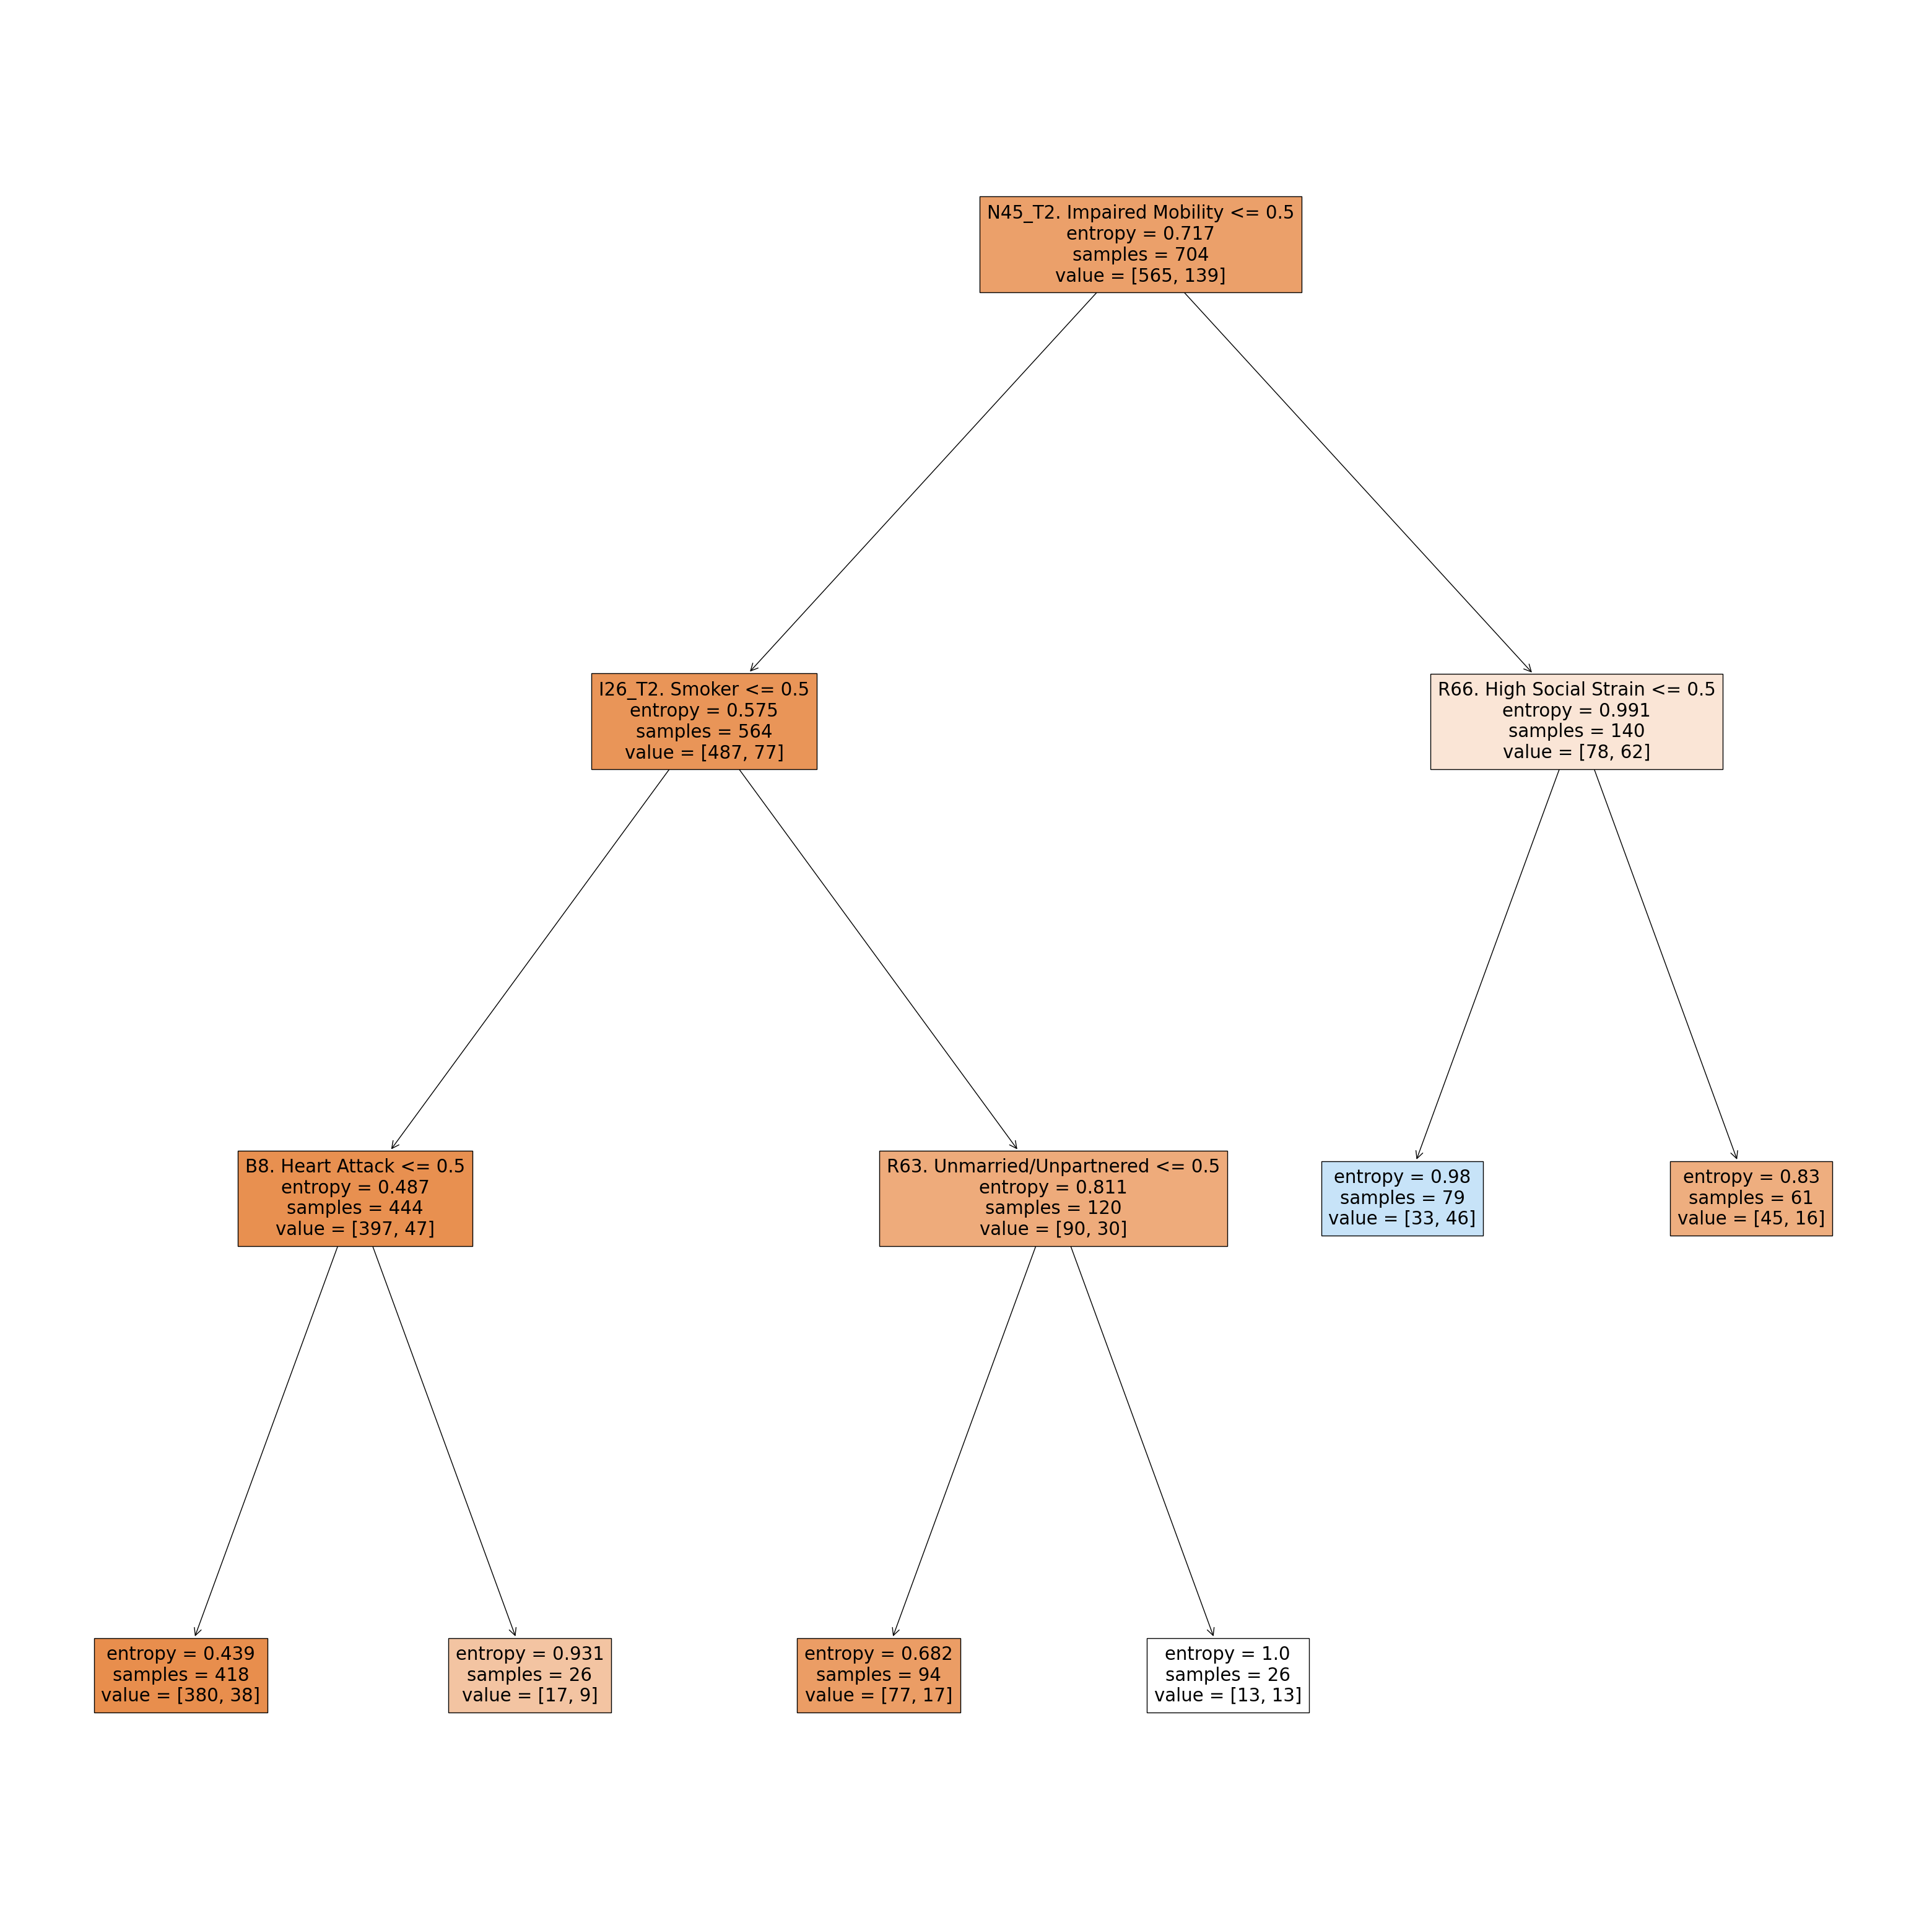

Performence on train set 0.8210227272727273
Performence on test set 0.7457627118644068
              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85       142
         1.0       0.29      0.20      0.24        35

    accuracy                           0.75       177
   macro avg       0.55      0.54      0.54       177
weighted avg       0.71      0.75      0.73       177



In [49]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["age recode (3 categories)"] == 1]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.008)
DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))

772


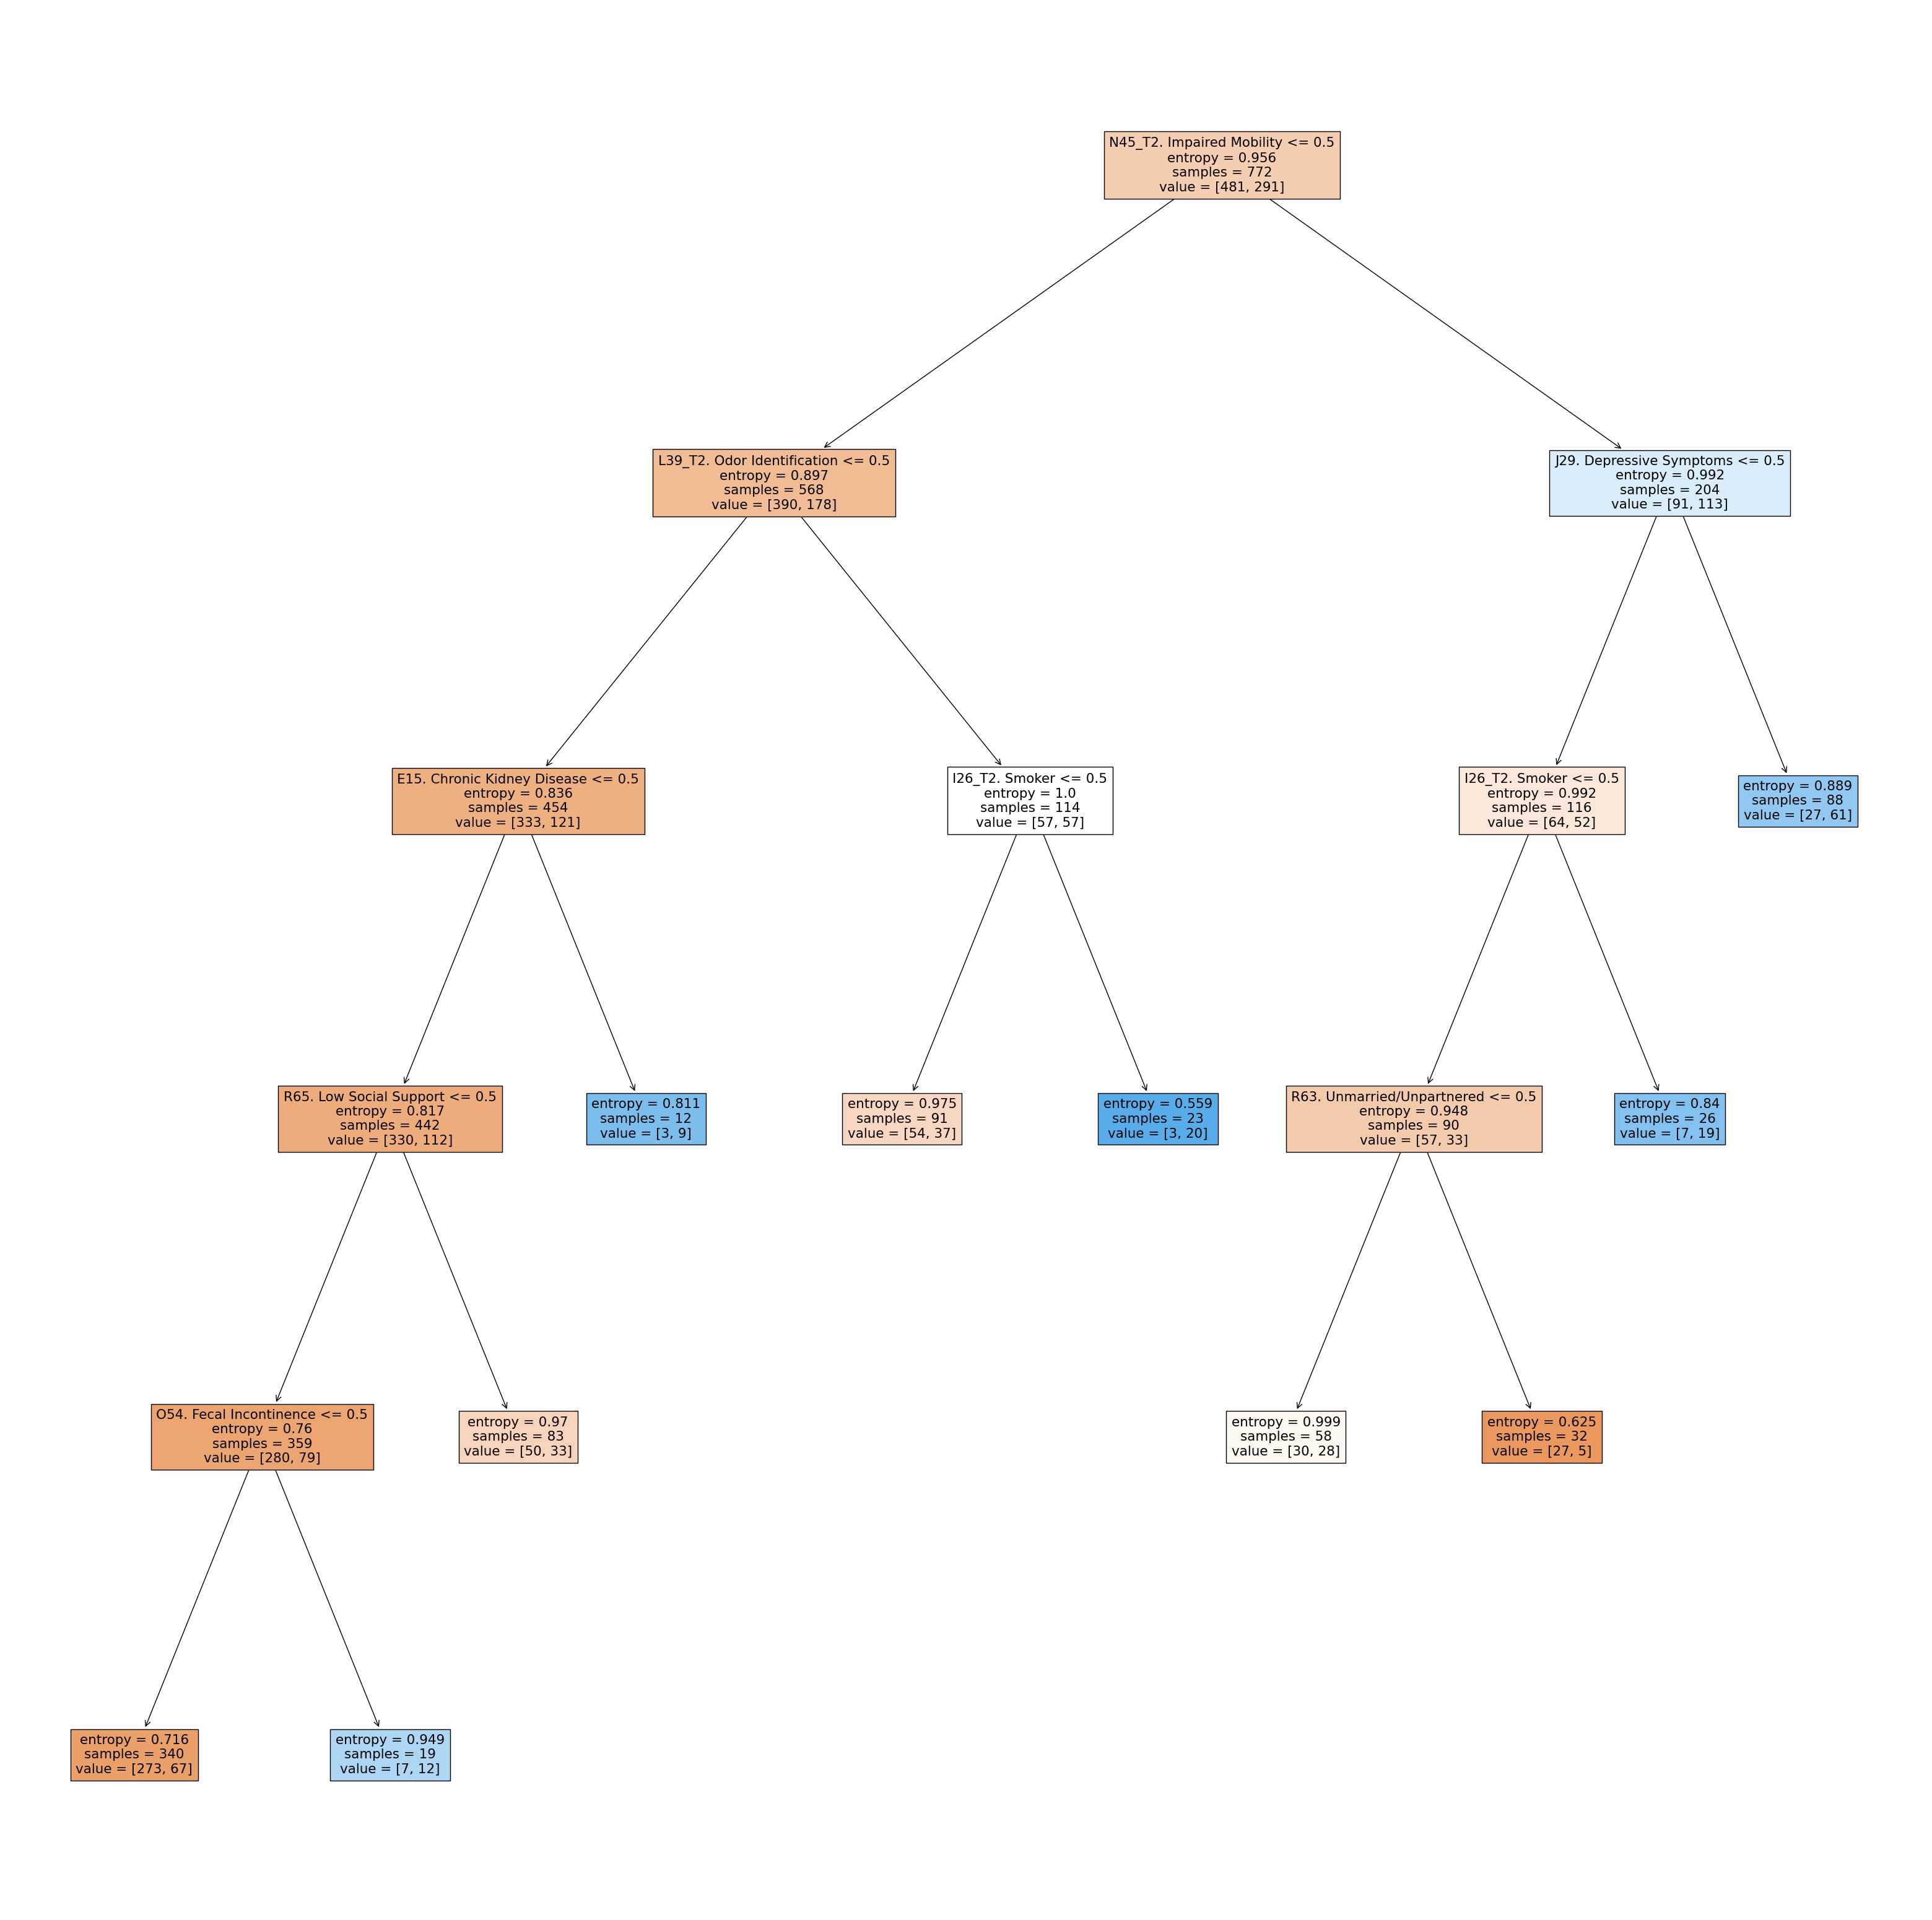

Performence on train set 0.7189119170984456
Performence on test set 0.6787564766839378
              precision    recall  f1-score   support

         0.0       0.70      0.86      0.77       120
         1.0       0.62      0.38      0.47        73

    accuracy                           0.68       193
   macro avg       0.66      0.62      0.62       193
weighted avg       0.67      0.68      0.66       193



In [50]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["age recode (3 categories)"] == 2]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.008)
DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))

668


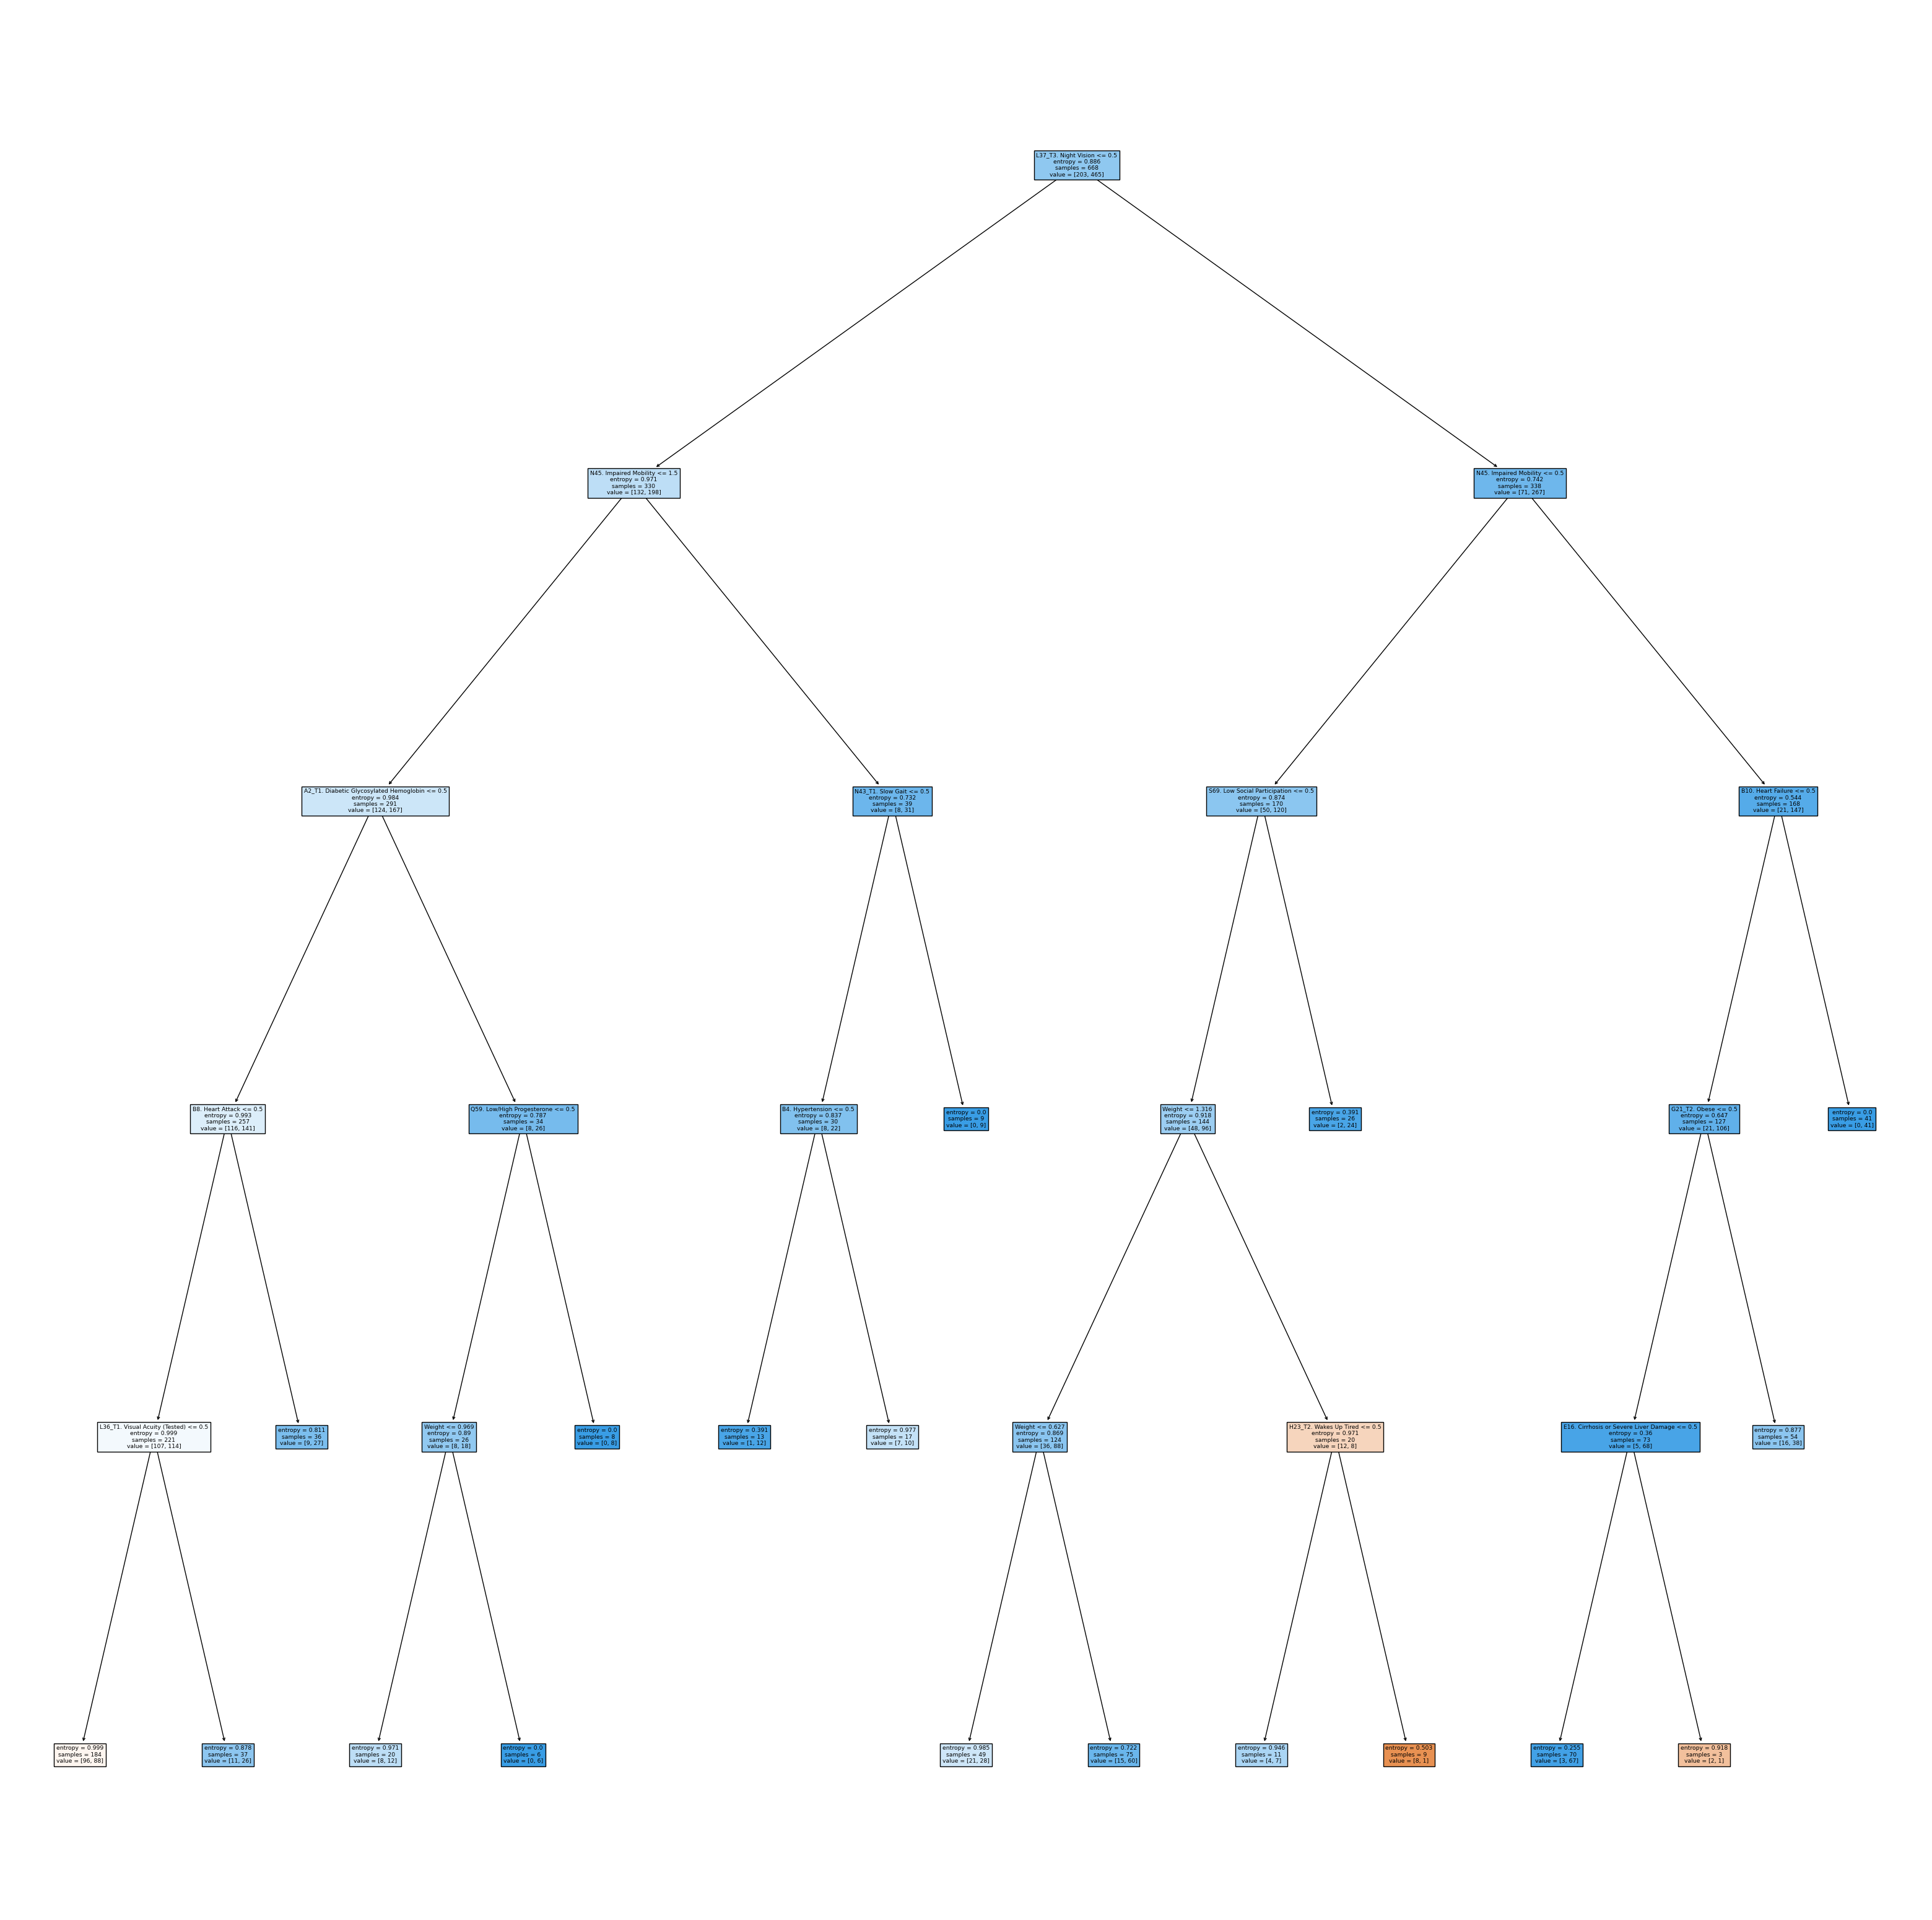

Performence on train set 0.7200598802395209
Performence on test set 0.6369047619047619
              precision    recall  f1-score   support

         0.0       0.41      0.43      0.42        51
         1.0       0.75      0.73      0.74       117

    accuracy                           0.64       168
   macro avg       0.58      0.58      0.58       168
weighted avg       0.64      0.64      0.64       168



In [53]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["age recode (3 categories)"] == 3]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.005)
DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))

## Education

504


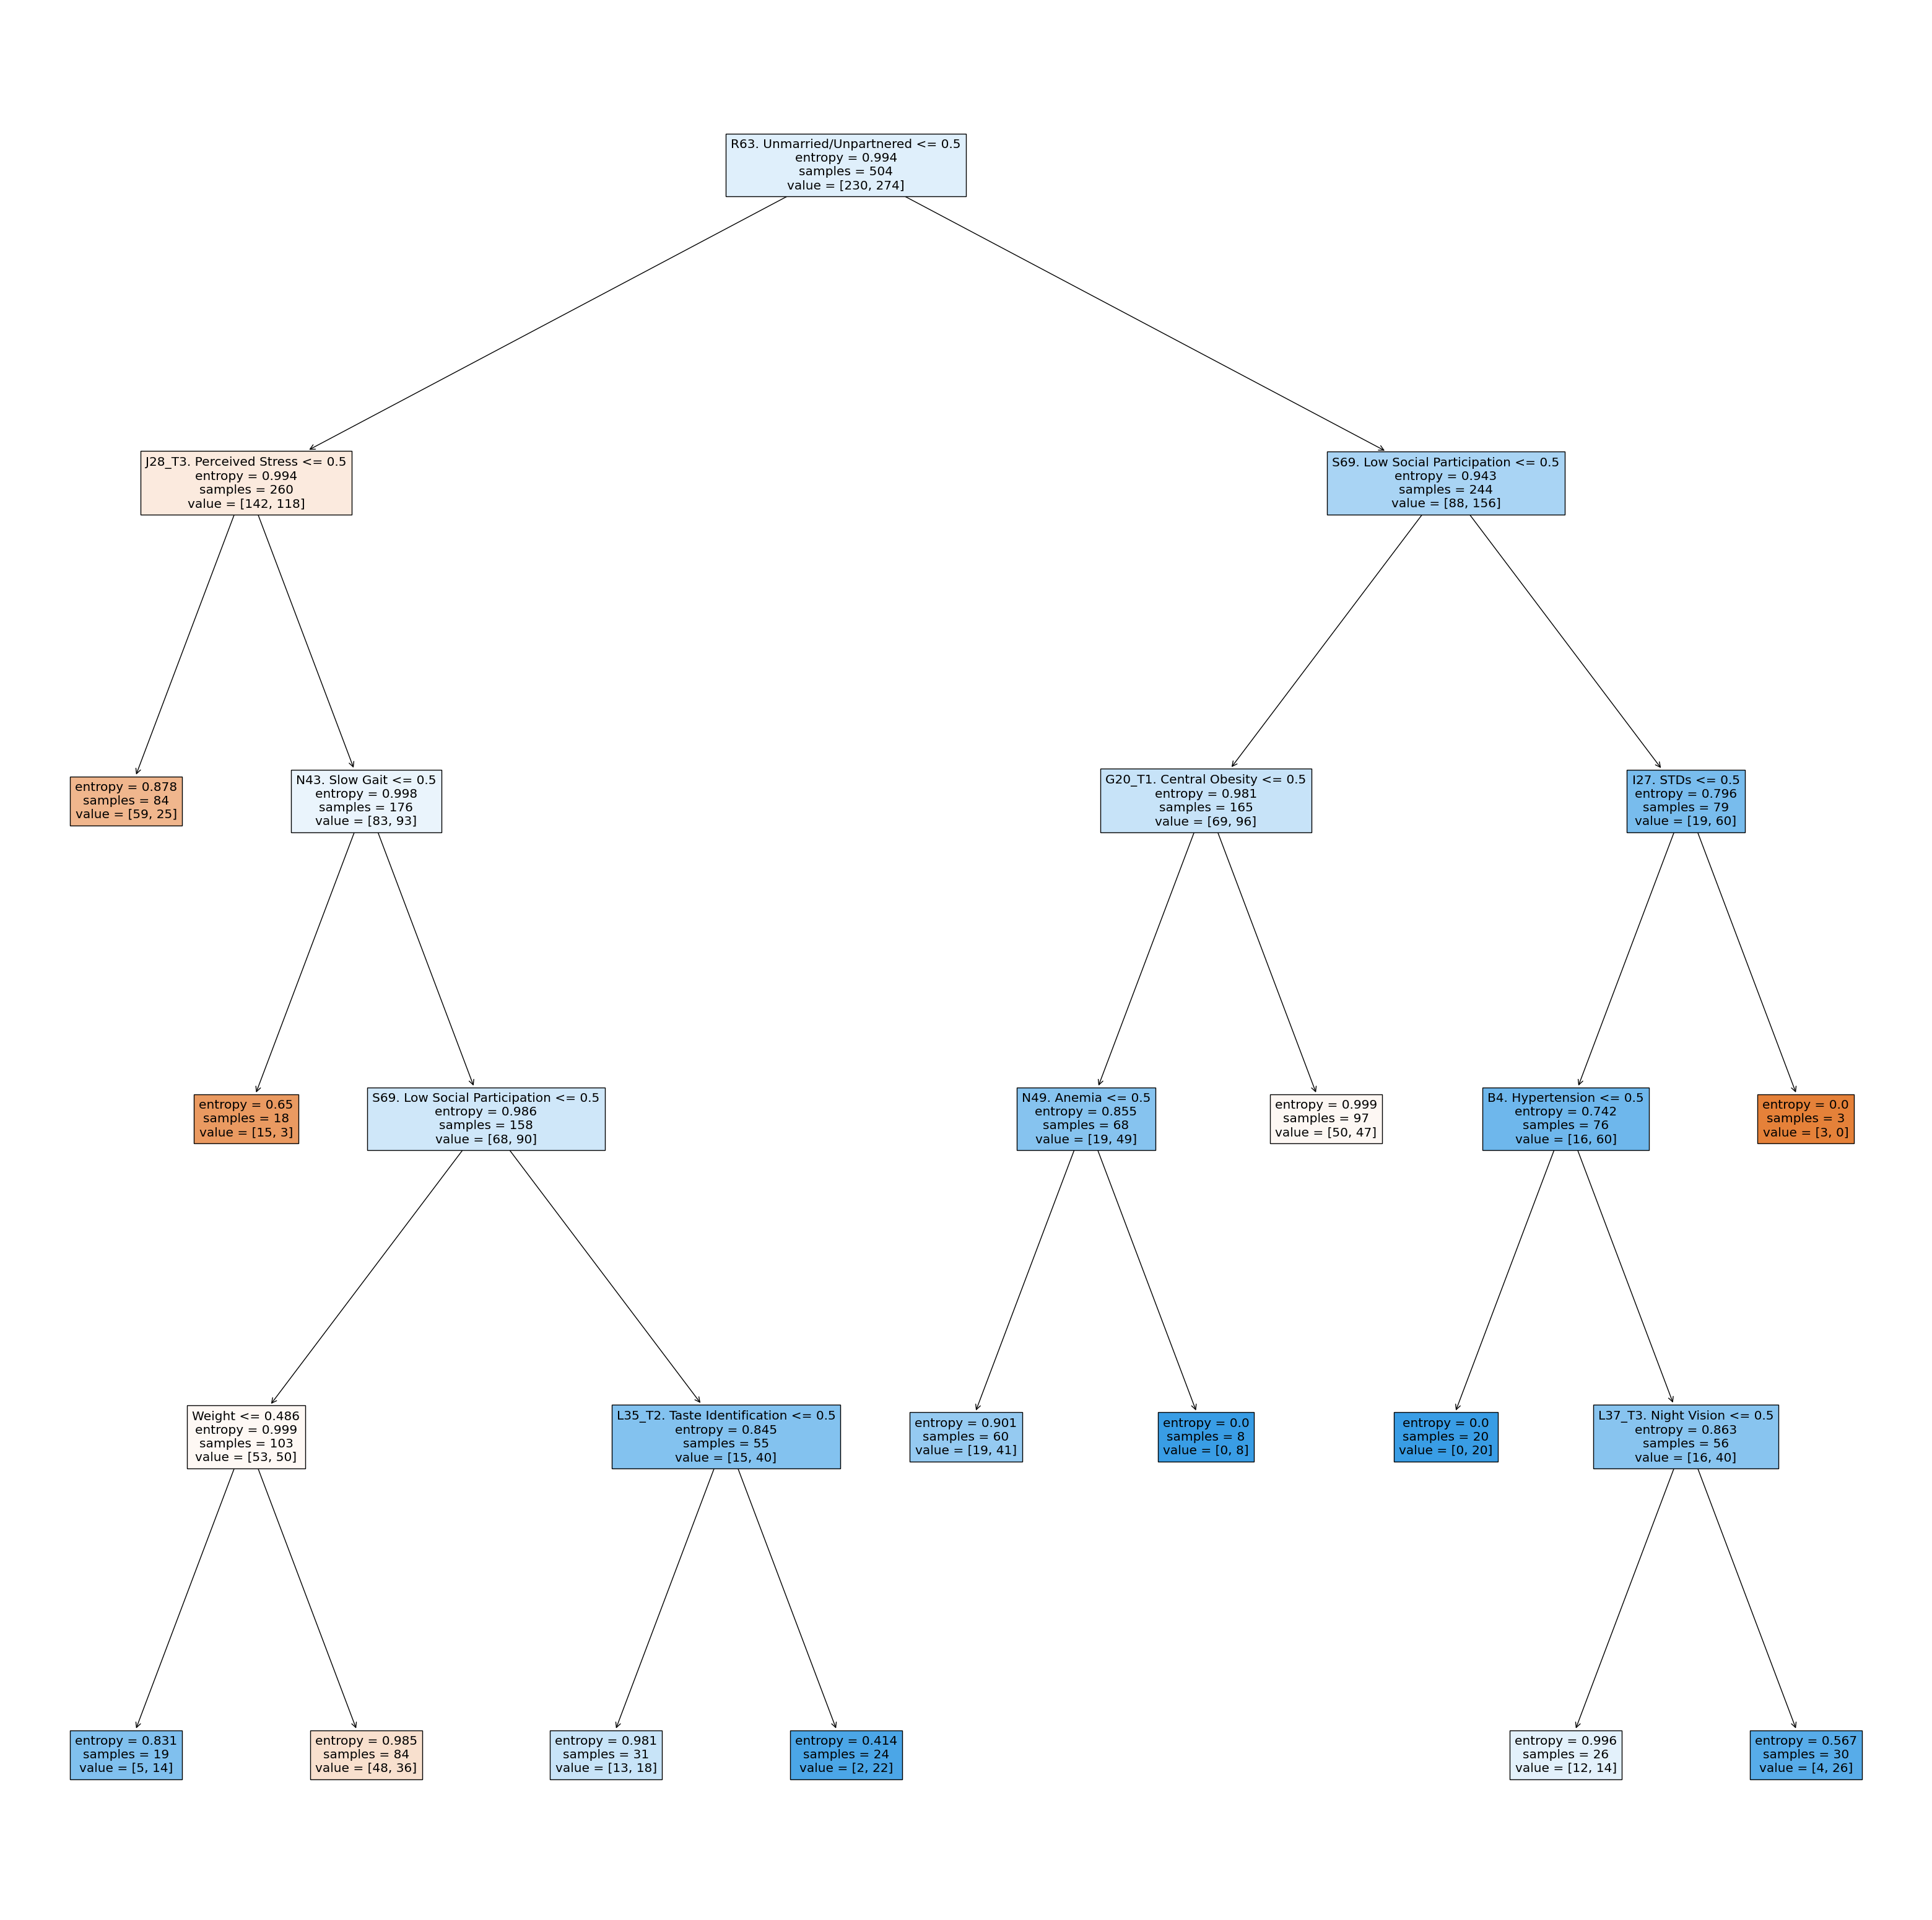

Performence on train set 0.6706349206349206
Performence on test set 0.5873015873015873
              precision    recall  f1-score   support

         0.0       0.54      0.71      0.61        58
         1.0       0.66      0.49      0.56        68

    accuracy                           0.59       126
   macro avg       0.60      0.60      0.59       126
weighted avg       0.60      0.59      0.58       126



In [54]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["education recode (4 categories)"] == 1]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.008)
DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))

563


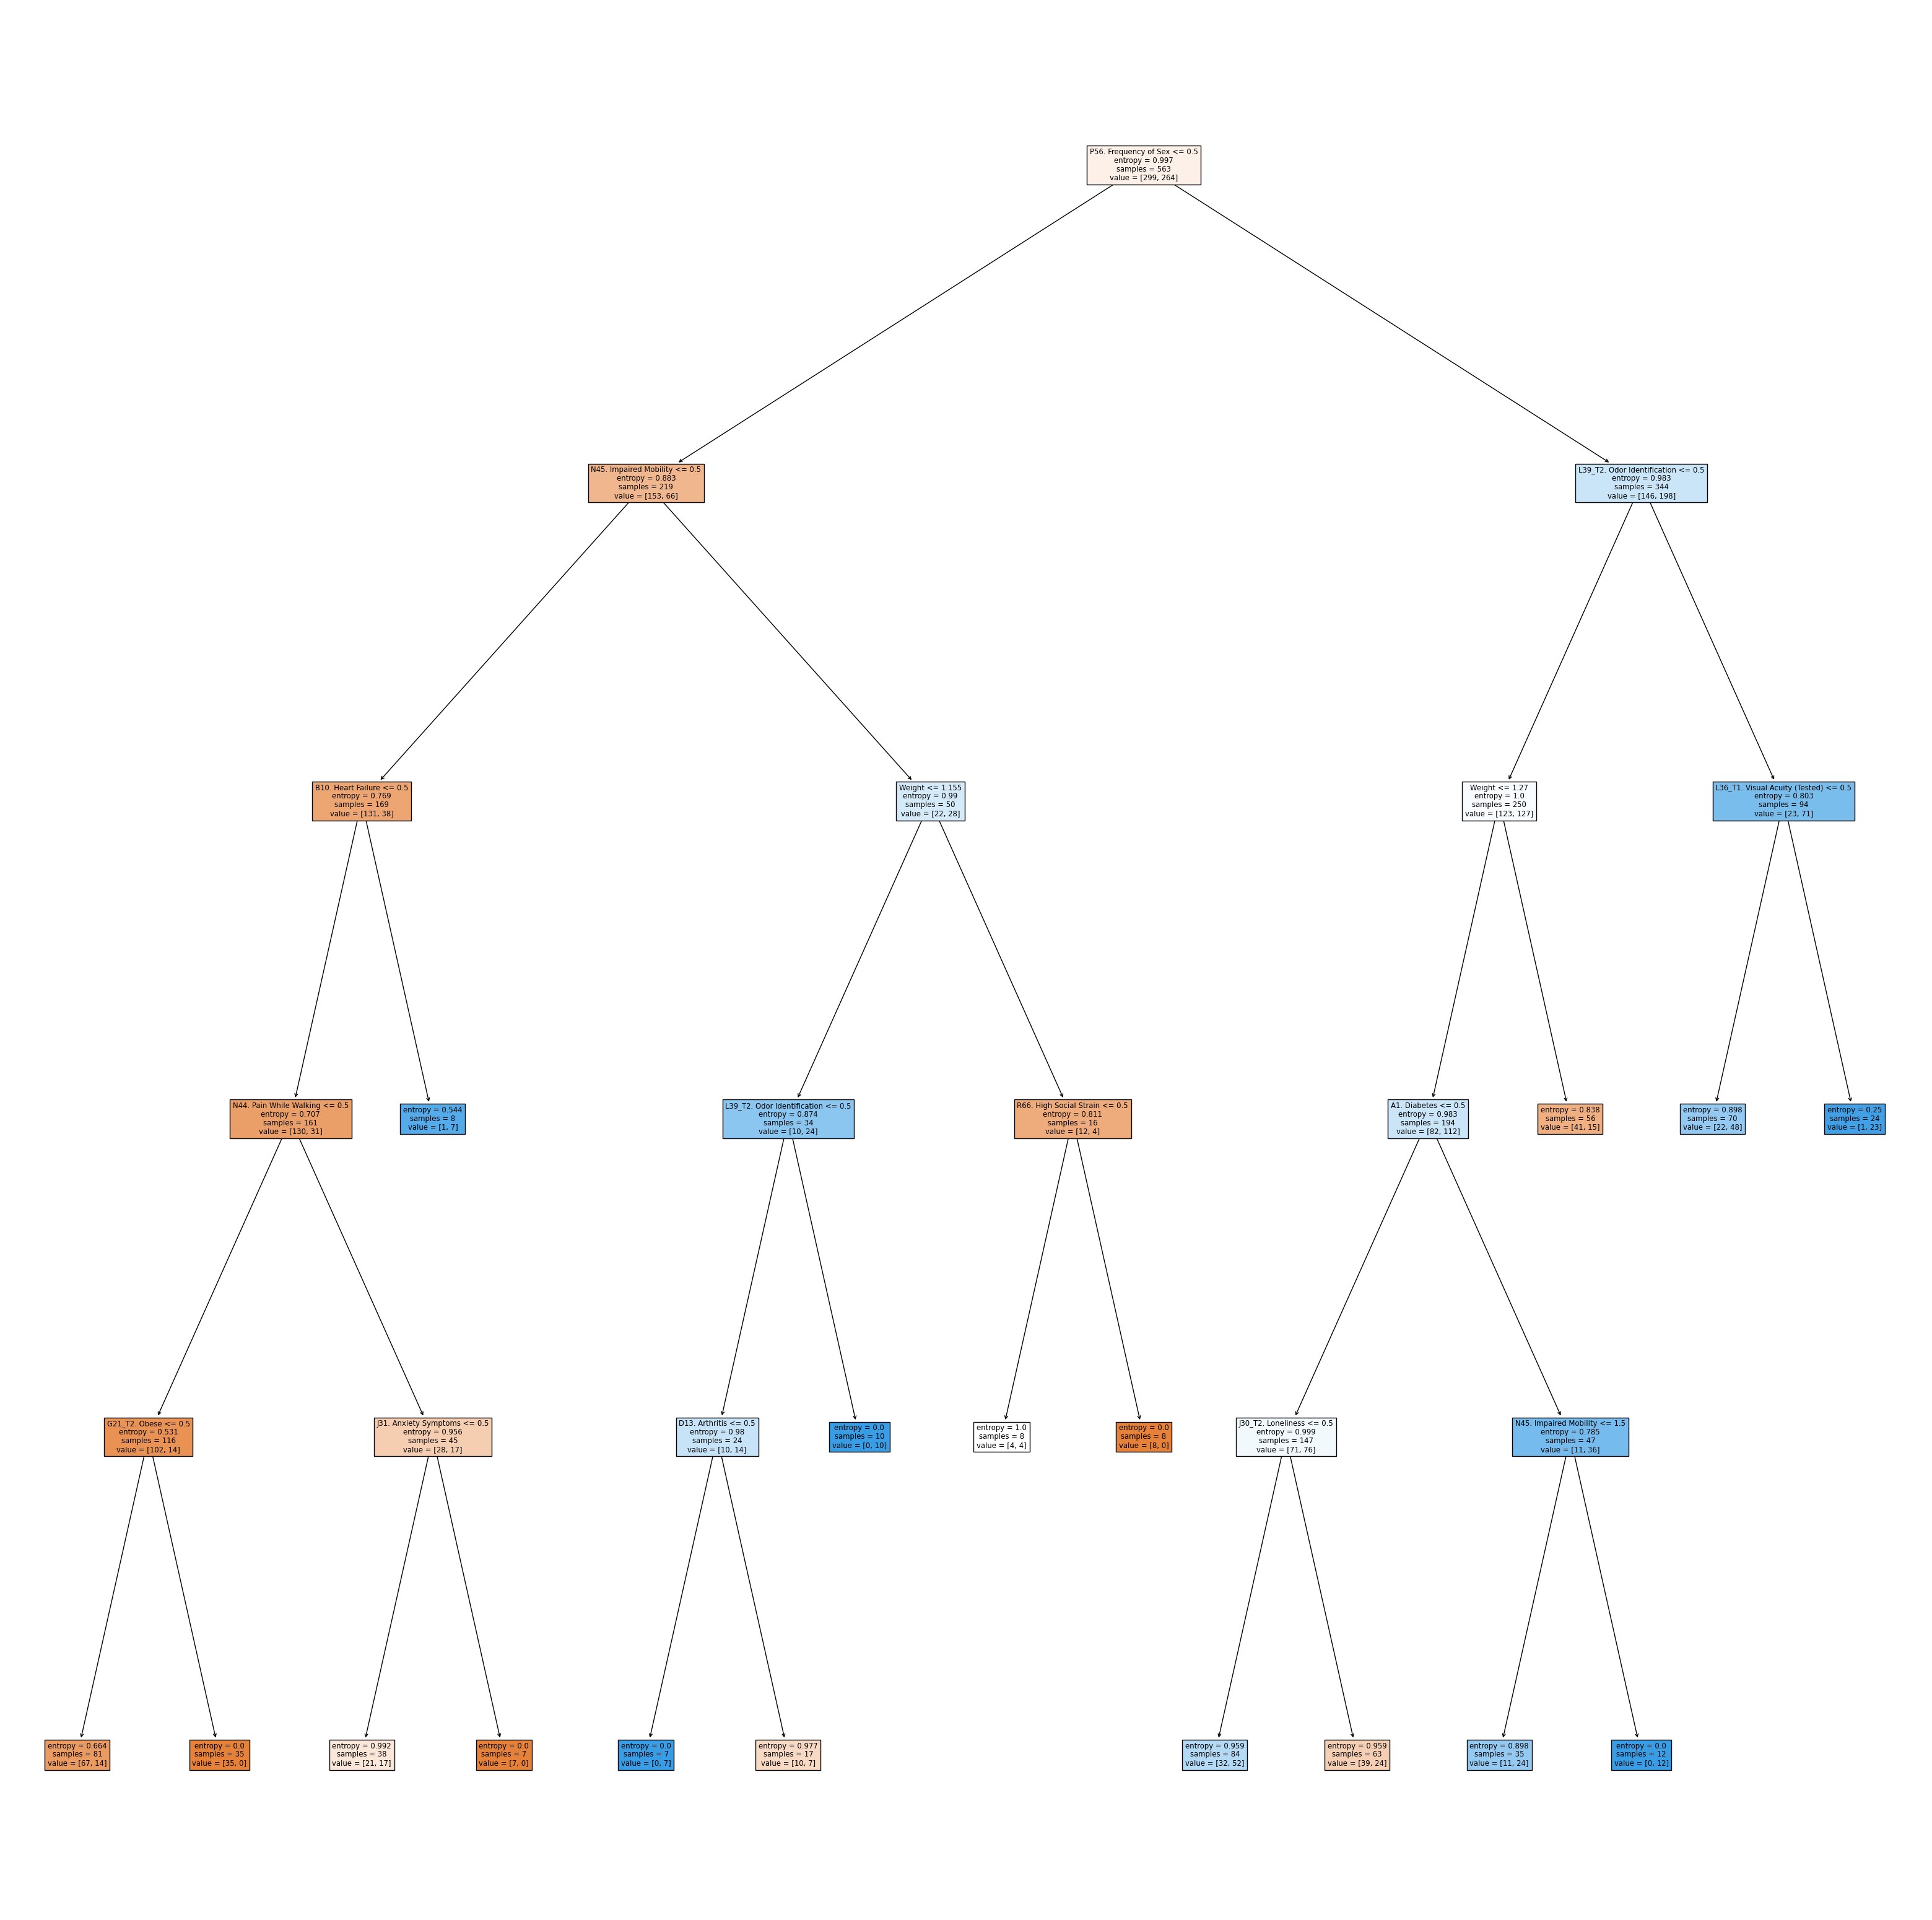

Performence on train set 0.7371225577264654
Performence on test set 0.7021276595744681
              precision    recall  f1-score   support

         0.0       0.69      0.81      0.74        75
         1.0       0.73      0.58      0.64        66

    accuracy                           0.70       141
   macro avg       0.71      0.69      0.69       141
weighted avg       0.71      0.70      0.70       141



In [55]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["education recode (4 categories)"] == 2]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.008)
DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))

610


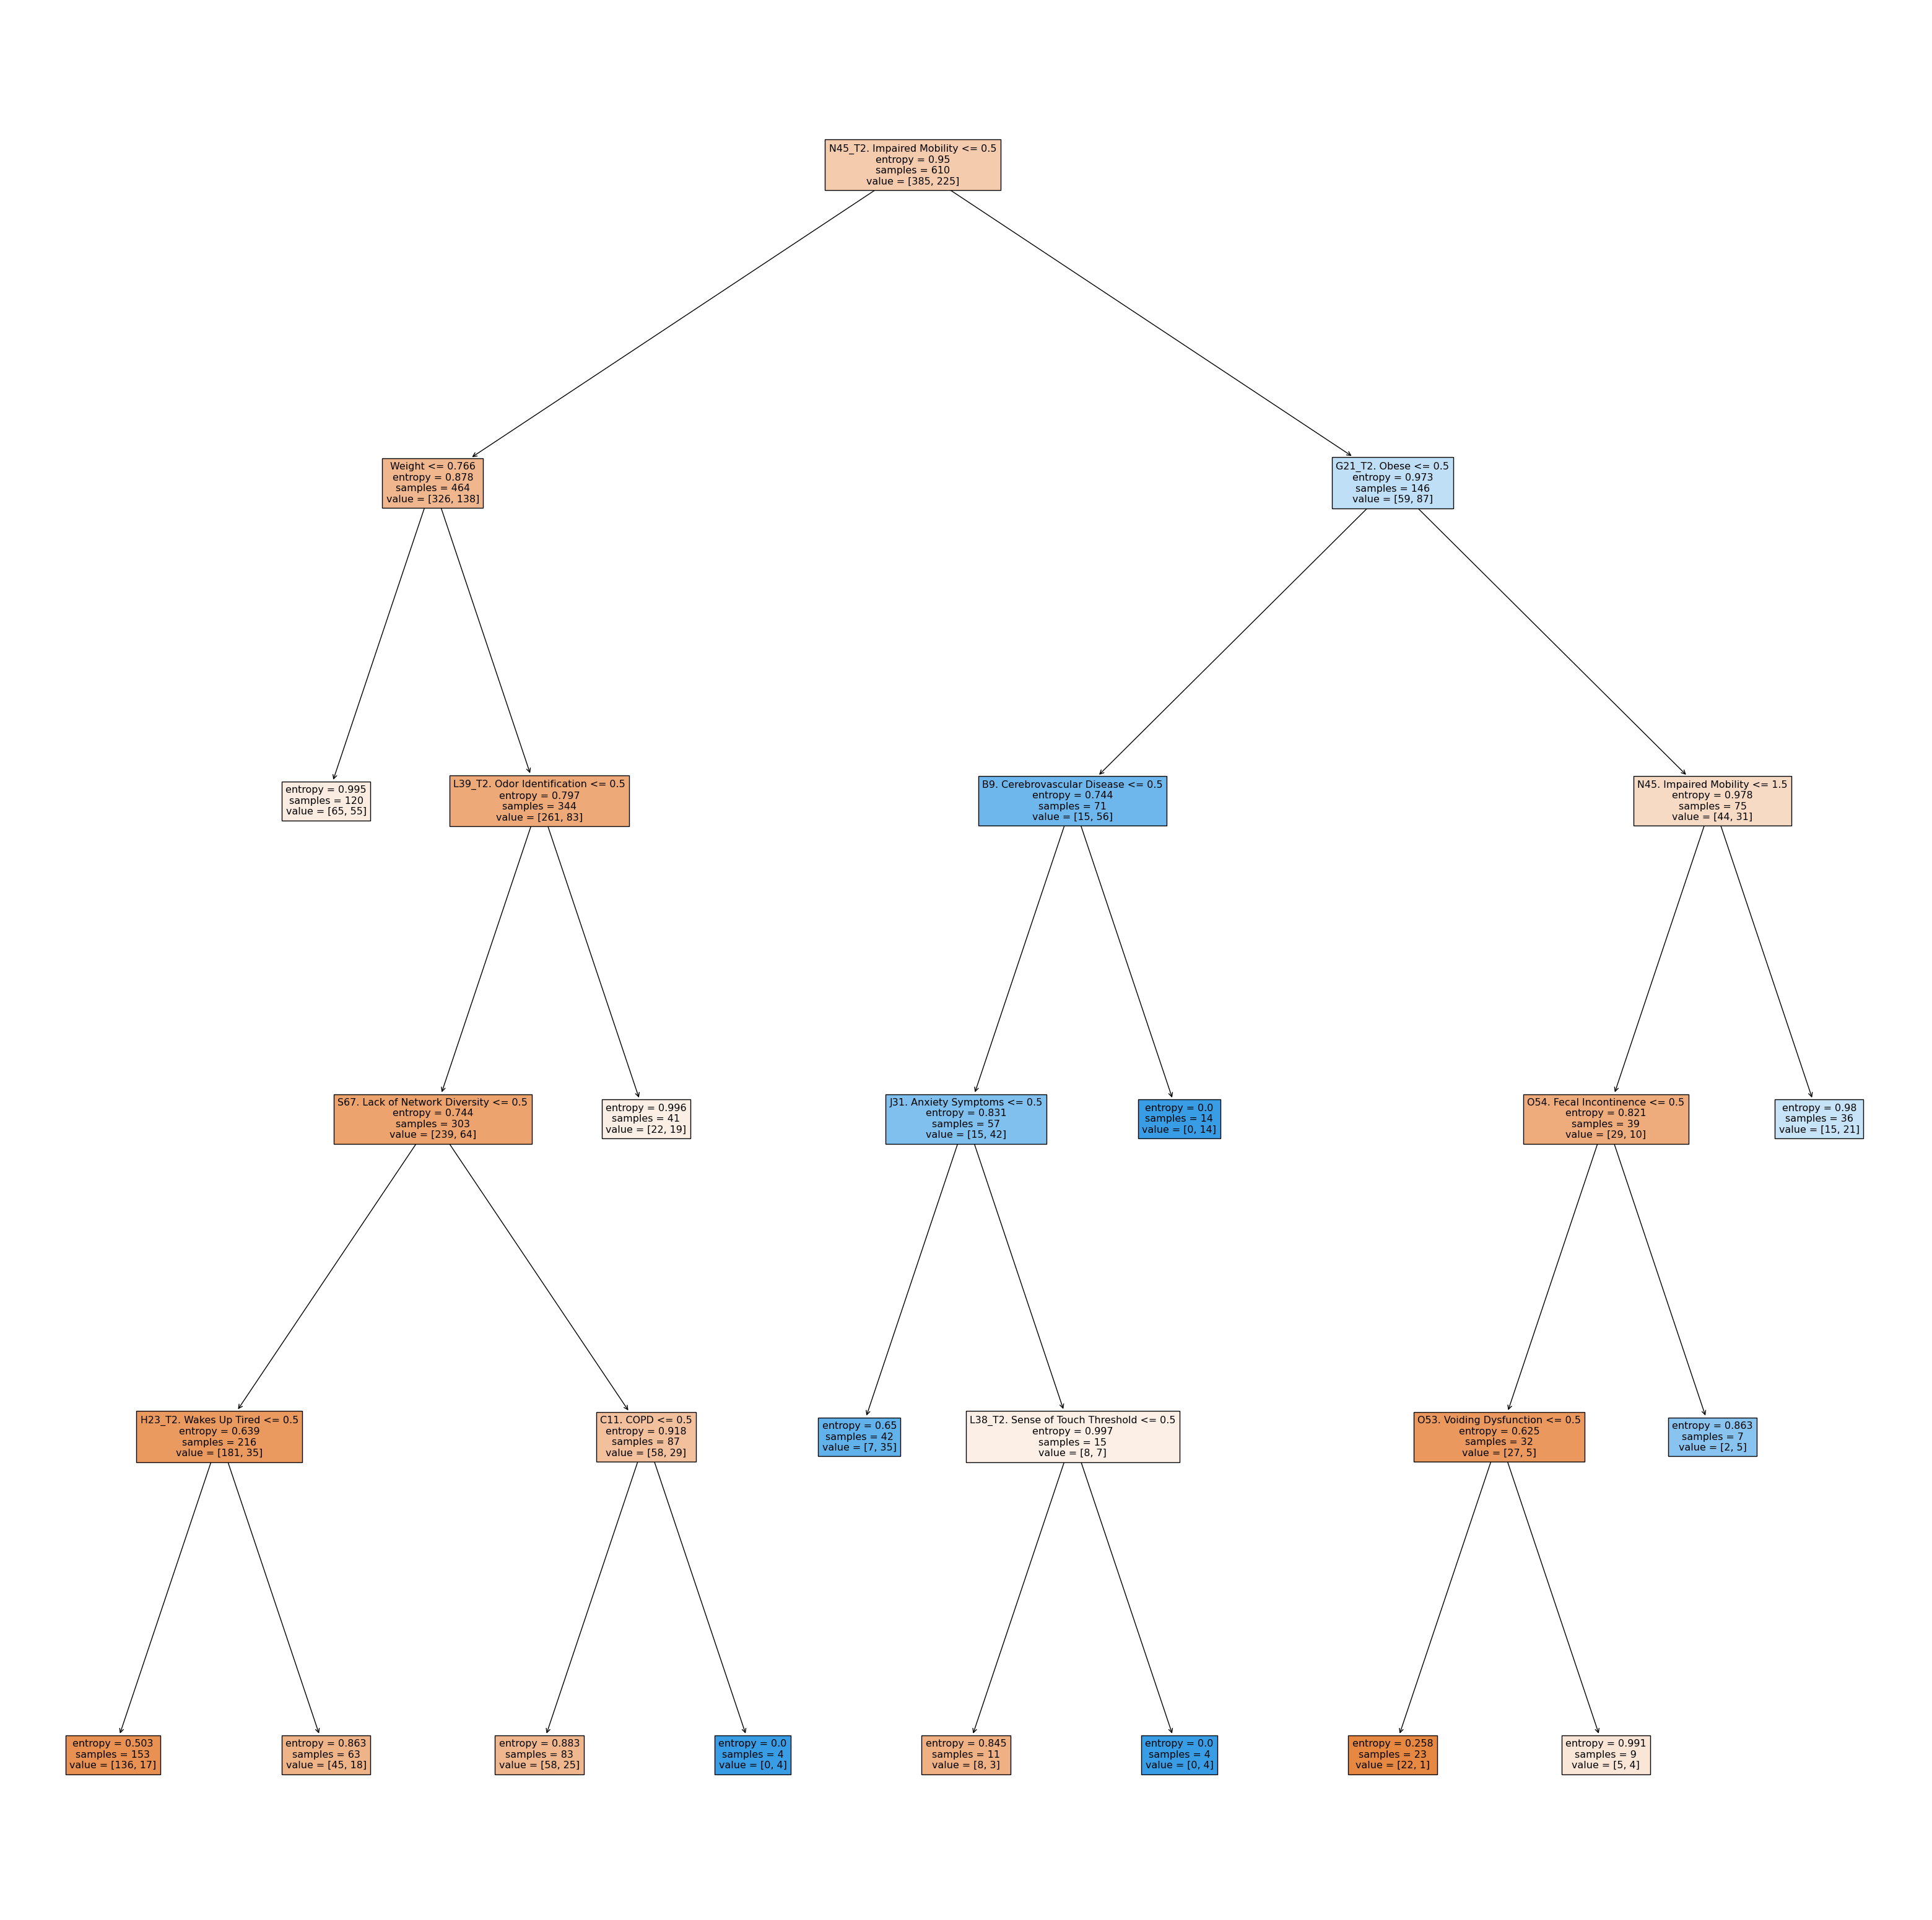

Performence on train set 0.7278688524590164
Performence on test set 0.7124183006535948
              precision    recall  f1-score   support

         0.0       0.72      0.90      0.80        97
         1.0       0.69      0.39      0.50        56

    accuracy                           0.71       153
   macro avg       0.70      0.64      0.65       153
weighted avg       0.71      0.71      0.69       153



In [56]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["education recode (4 categories)"] == 3]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.008)
DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))

468


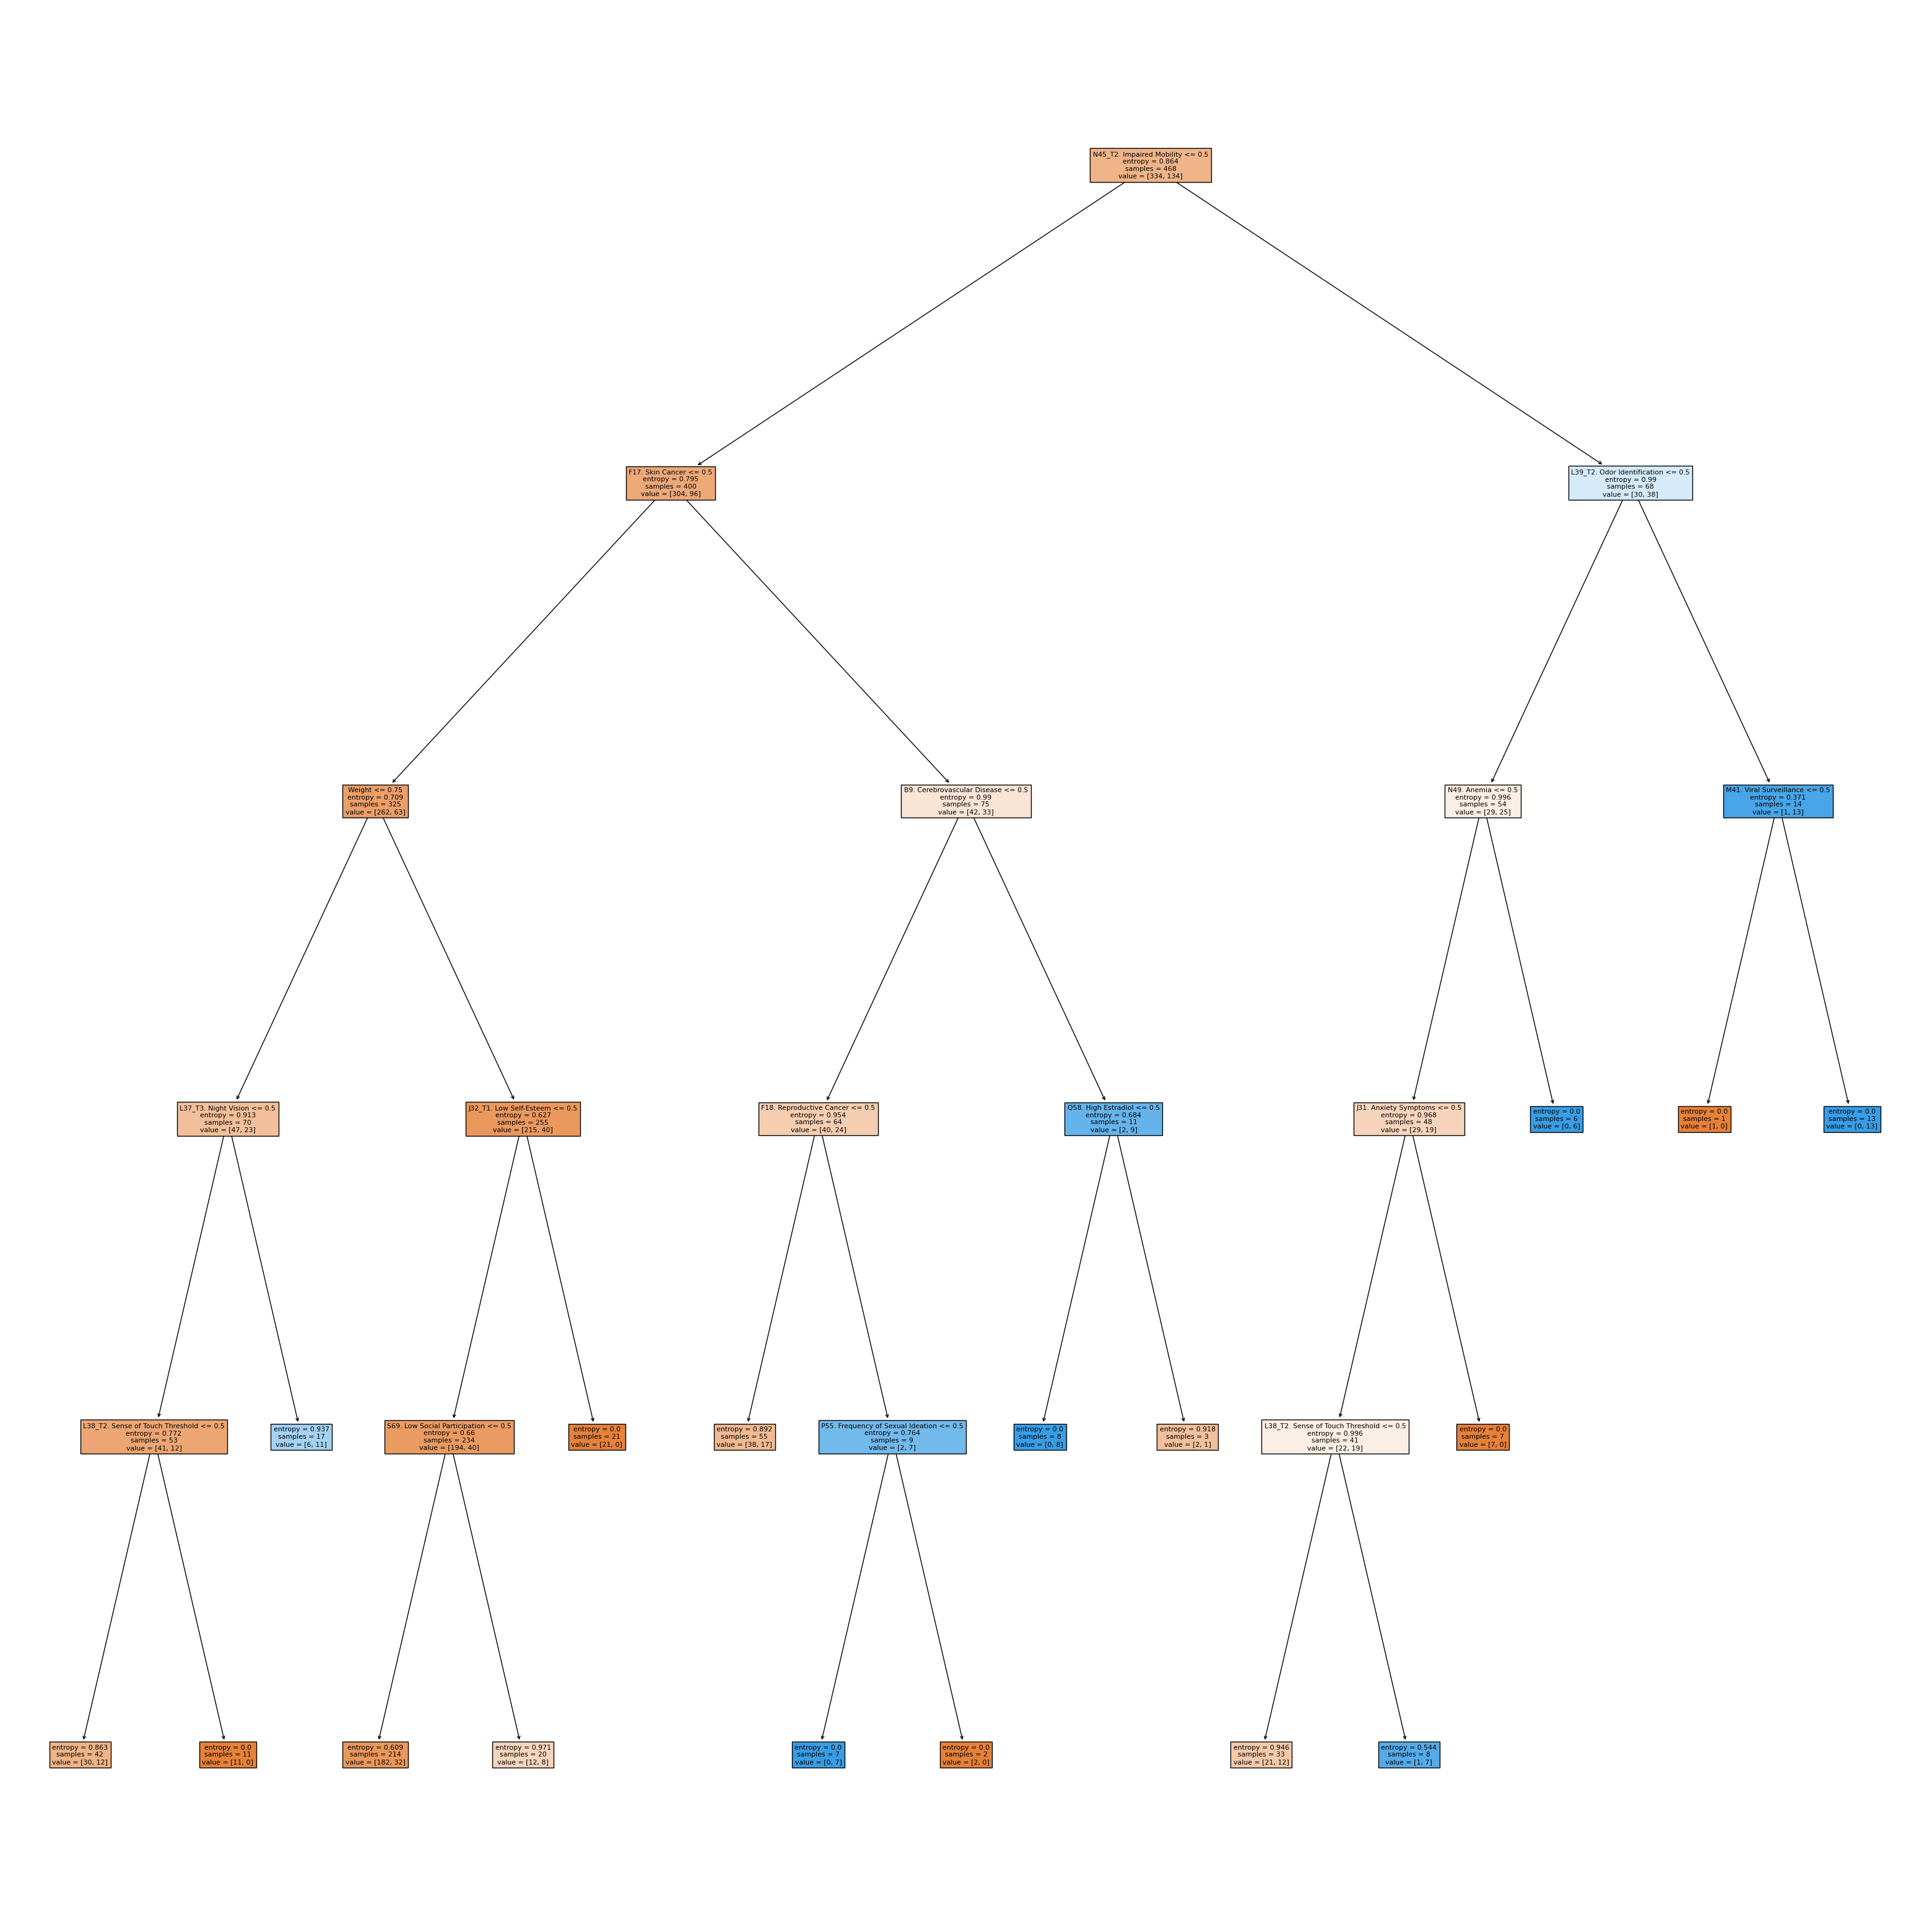

Performence on train set 0.8098290598290598
Performence on test set 0.7008547008547008
              precision    recall  f1-score   support

         0.0       0.73      0.92      0.81        84
         1.0       0.42      0.15      0.22        33

    accuracy                           0.70       117
   macro avg       0.57      0.53      0.52       117
weighted avg       0.64      0.70      0.65       117



In [57]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["education recode (4 categories)"] == 4]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.008)
DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))

## Race

1536


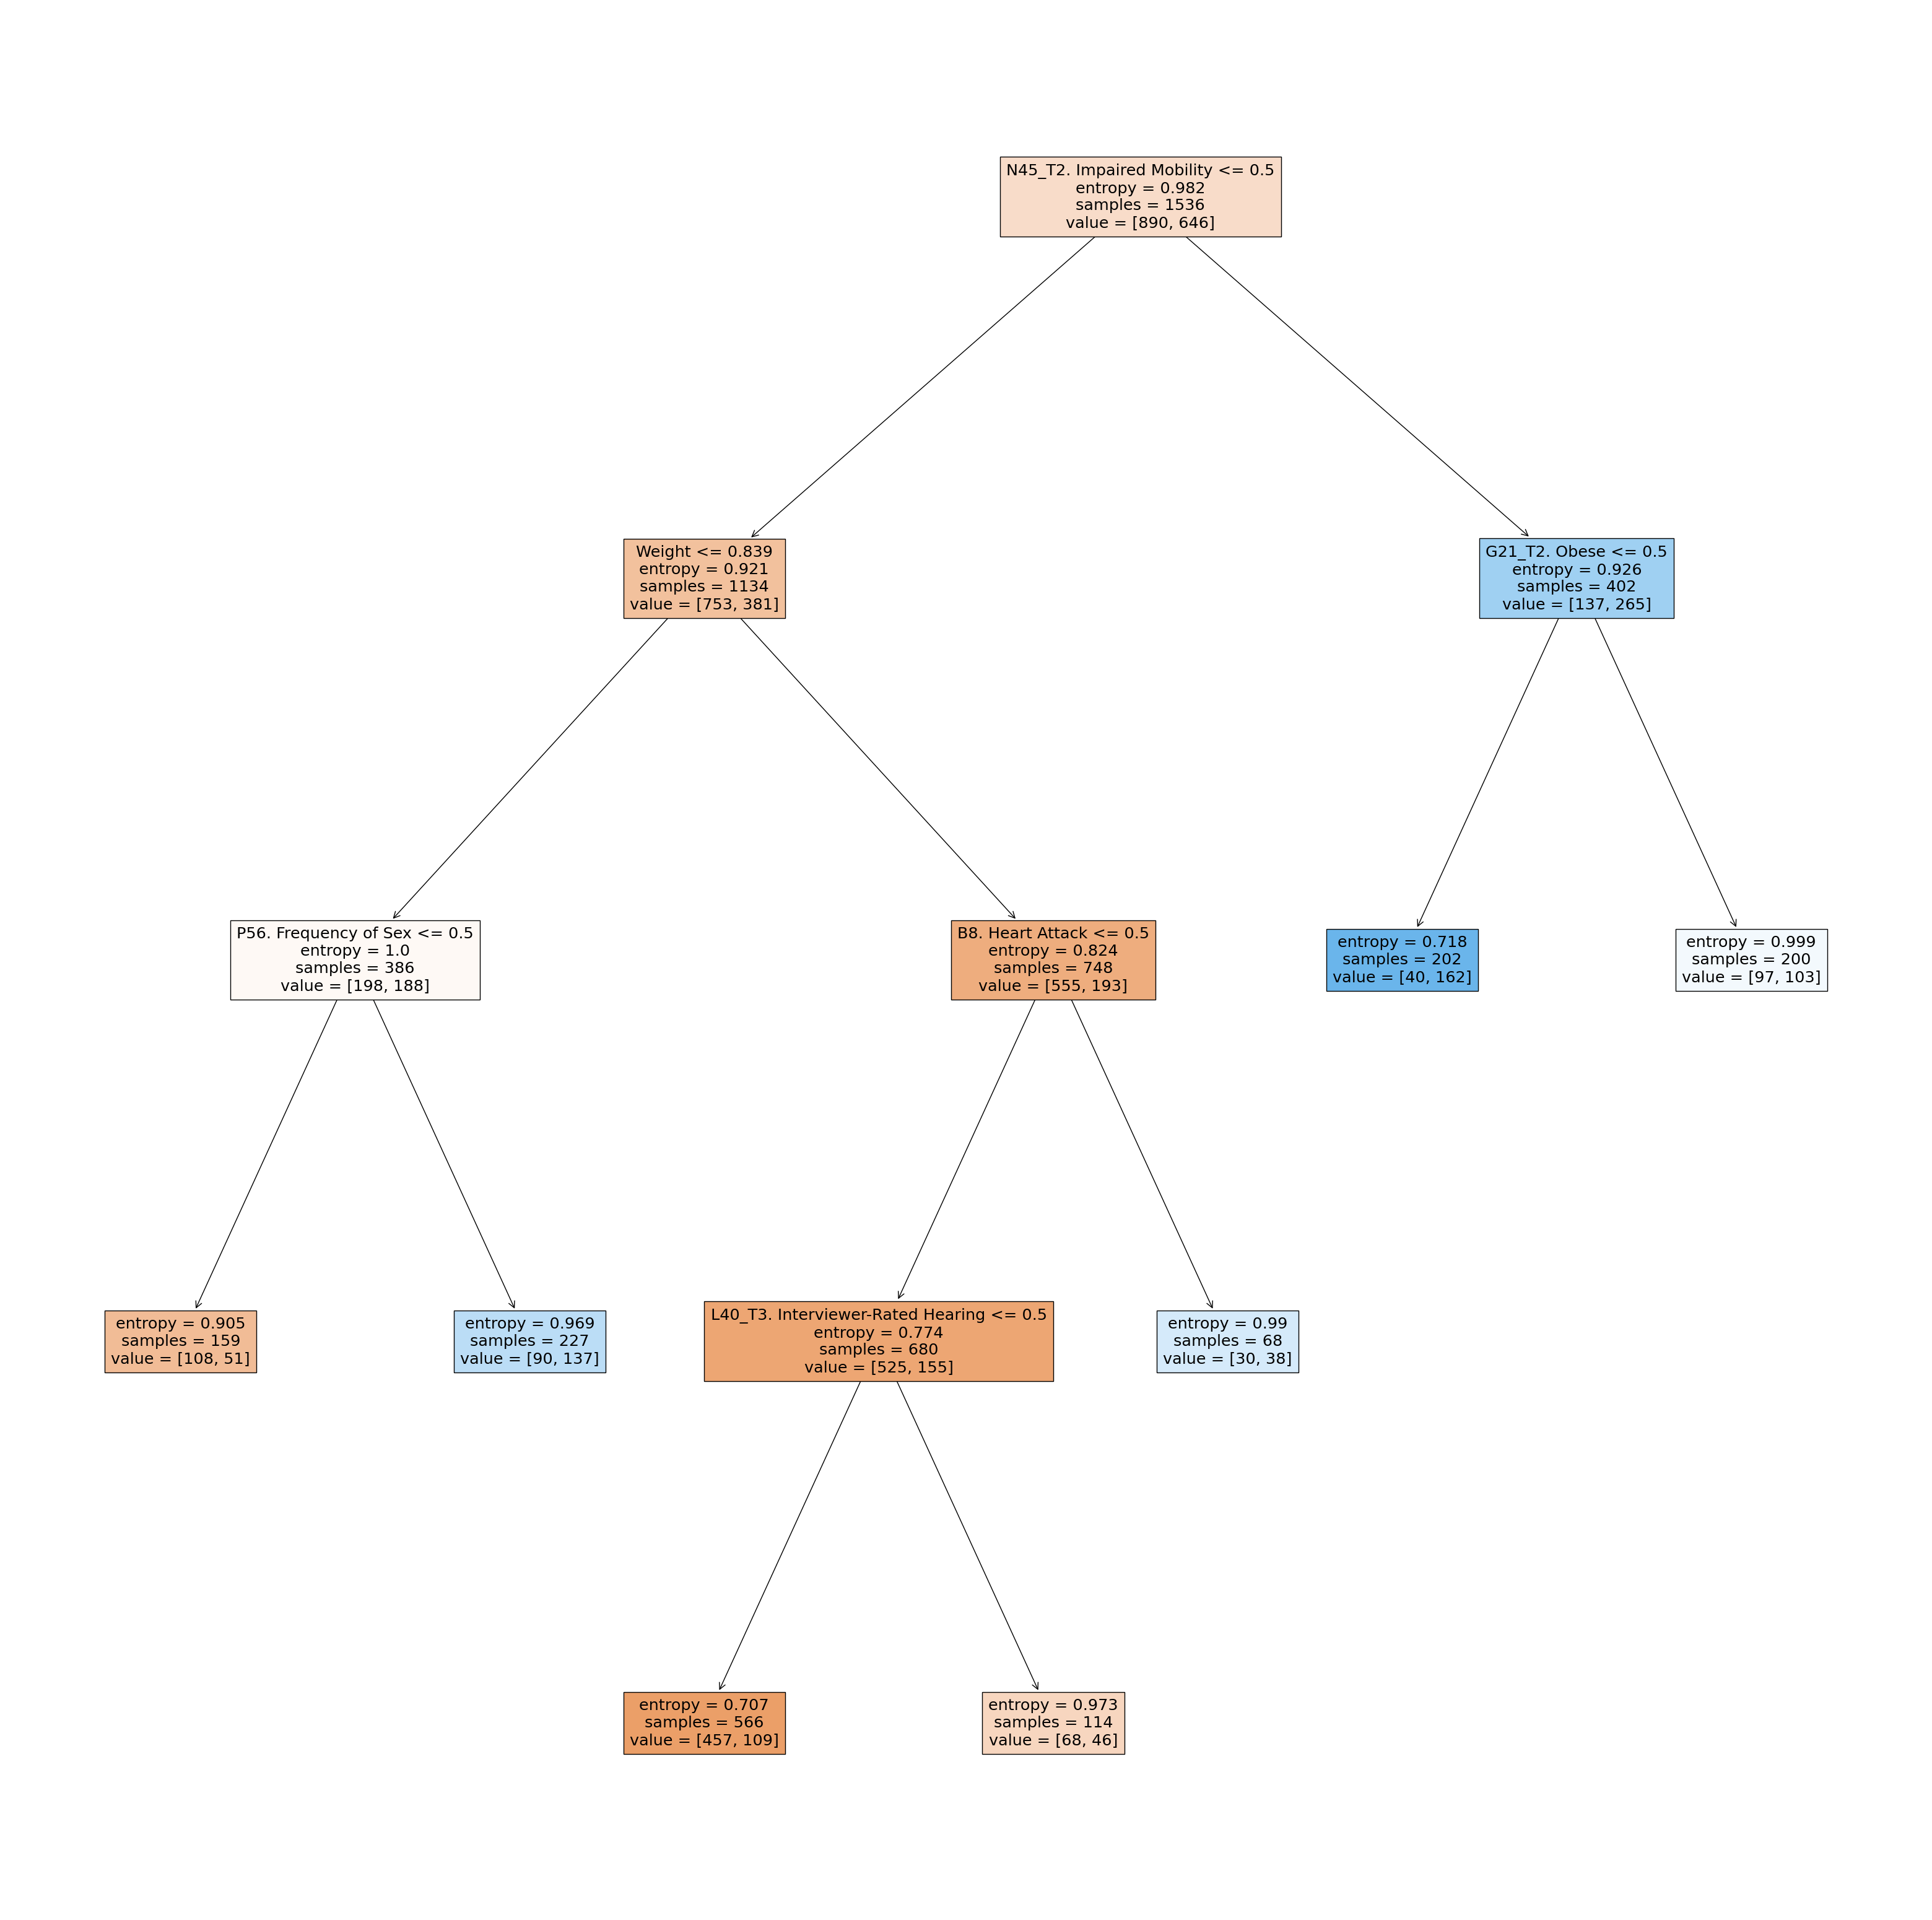

Performence on train set 0.6985677083333334
Performence on test set 0.65625
              precision    recall  f1-score   support

         0.0       0.71      0.69      0.70       223
         1.0       0.59      0.61      0.60       161

    accuracy                           0.66       384
   macro avg       0.65      0.65      0.65       384
weighted avg       0.66      0.66      0.66       384



In [58]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["race/ethnicity recode (4 categories)"] == 1]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.008)
DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))

361


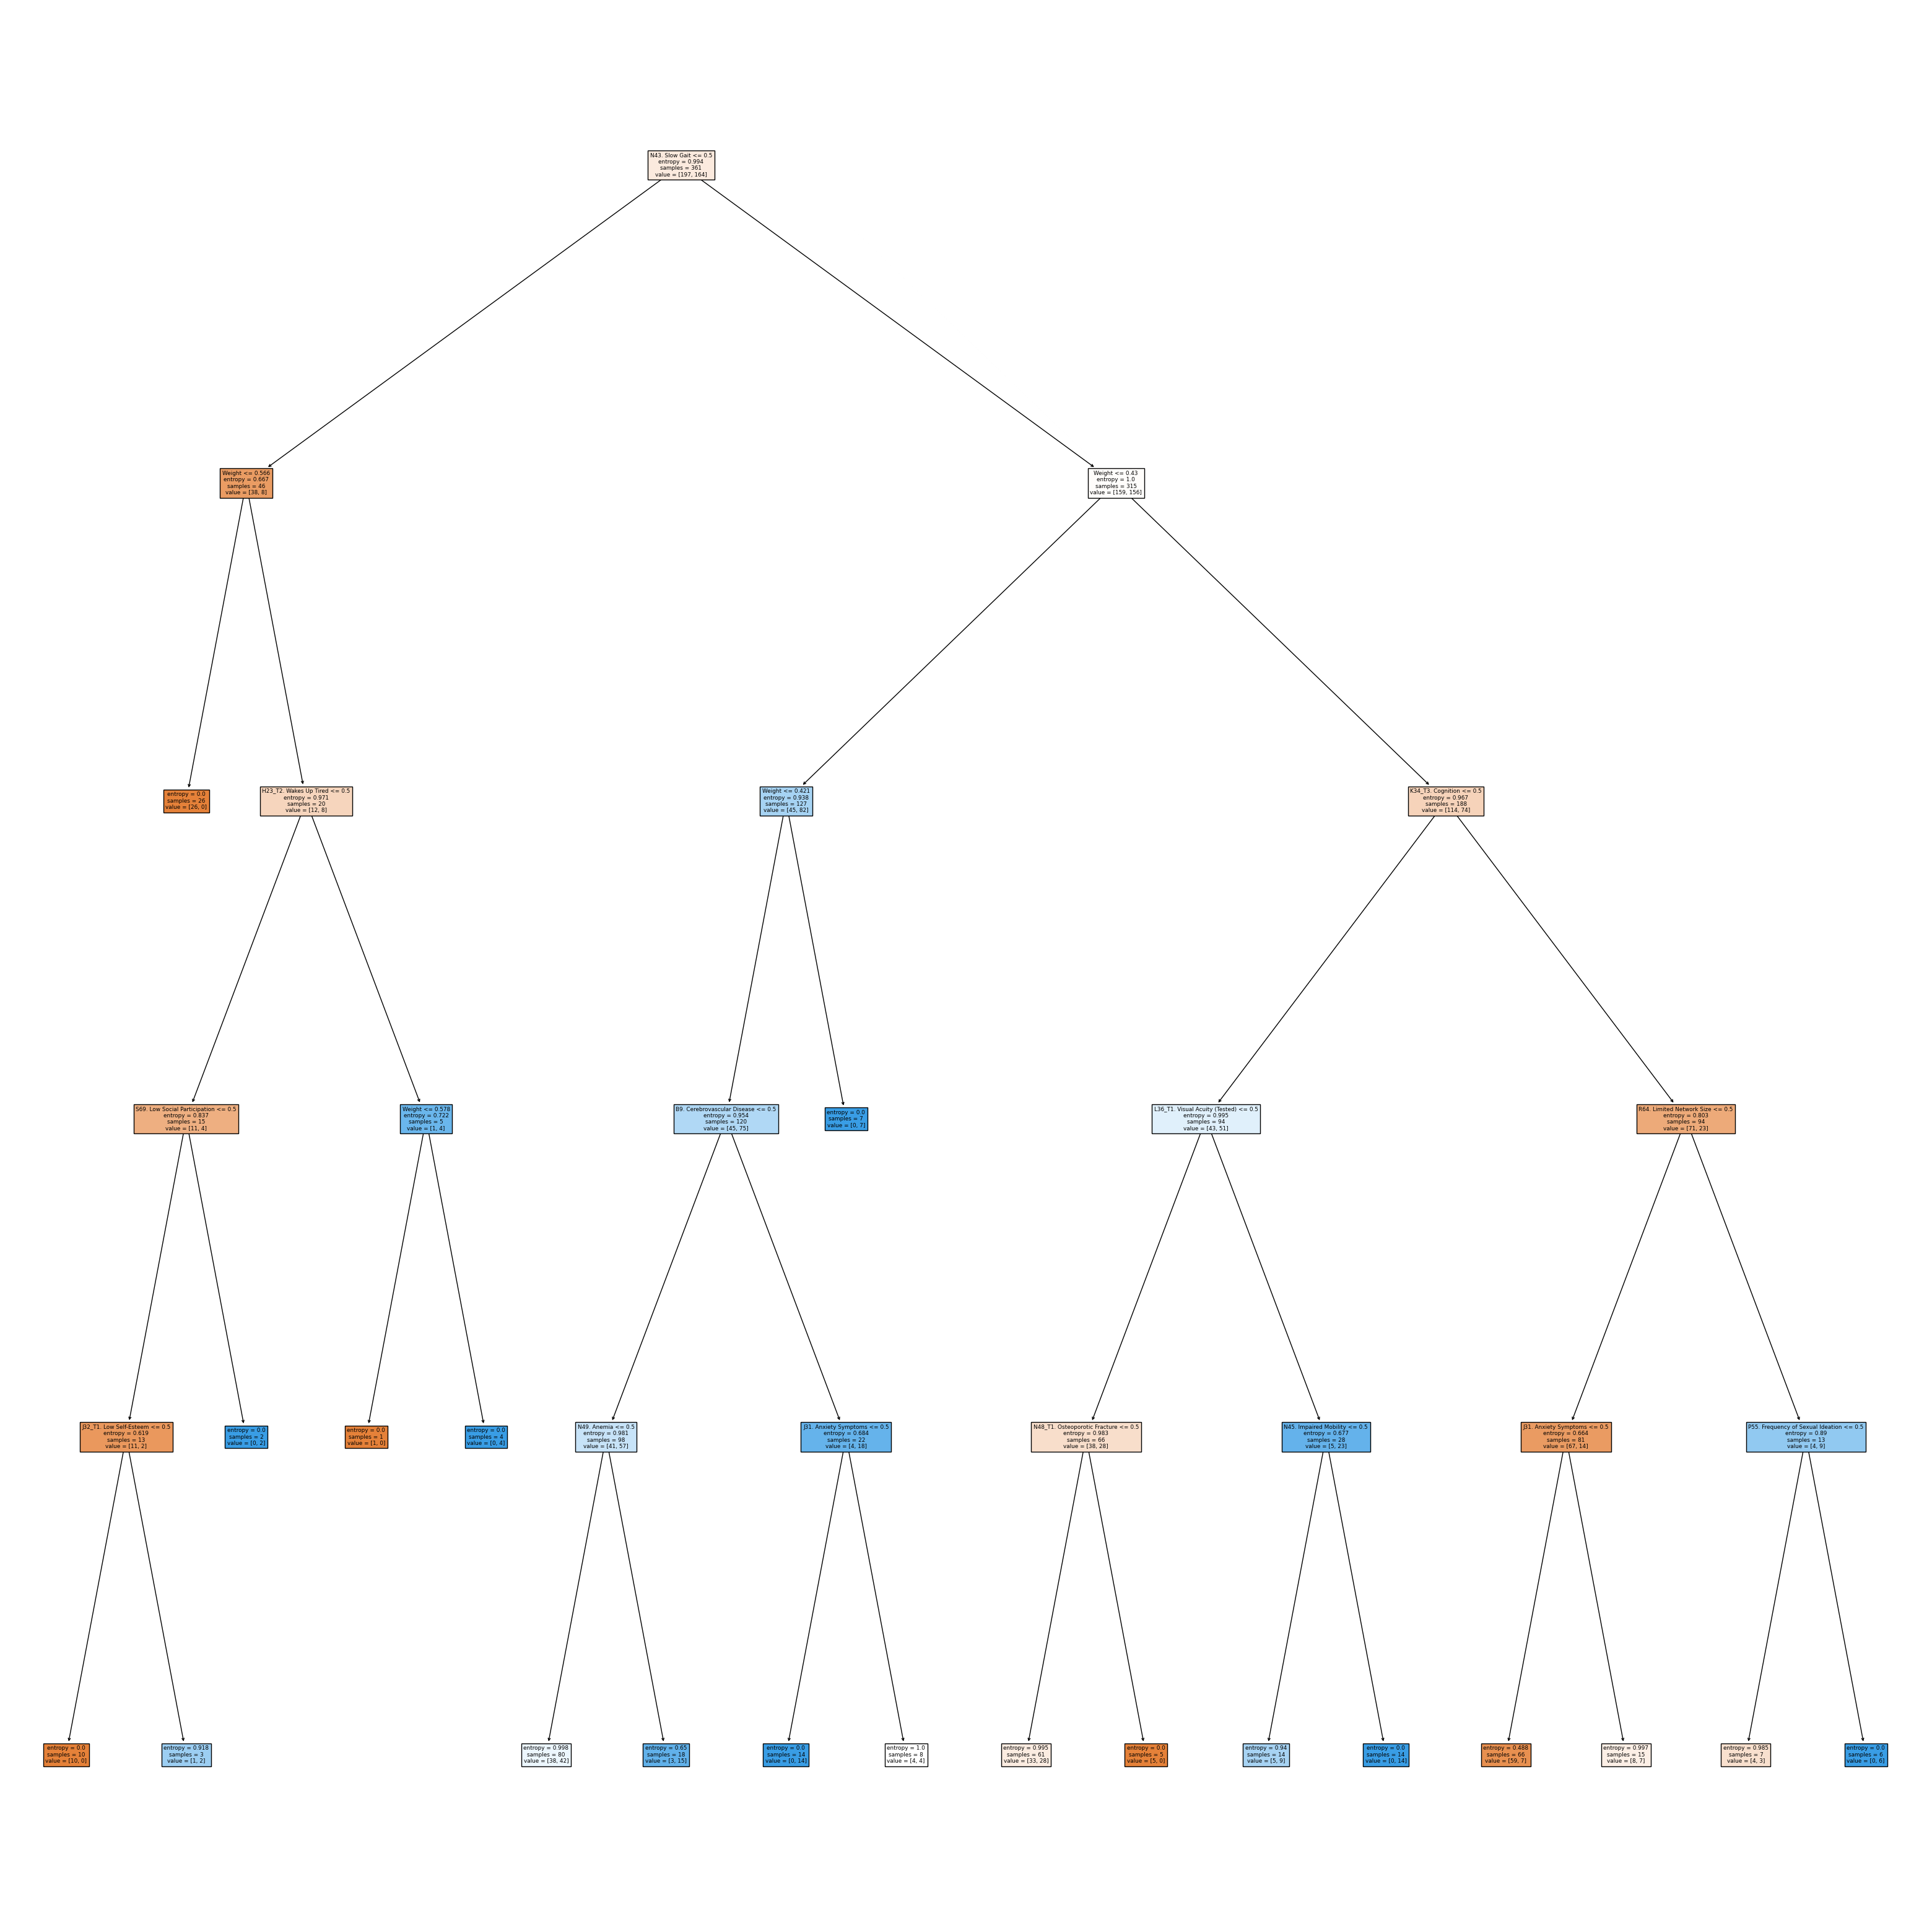

Performence on train set 0.7340720221606648
Performence on test set 0.6373626373626373
              precision    recall  f1-score   support

         0.0       0.65      0.72      0.69        50
         1.0       0.61      0.54      0.57        41

    accuracy                           0.64        91
   macro avg       0.63      0.63      0.63        91
weighted avg       0.63      0.64      0.63        91



In [59]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["race/ethnicity recode (4 categories)"] == 2]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.008)
DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))

204


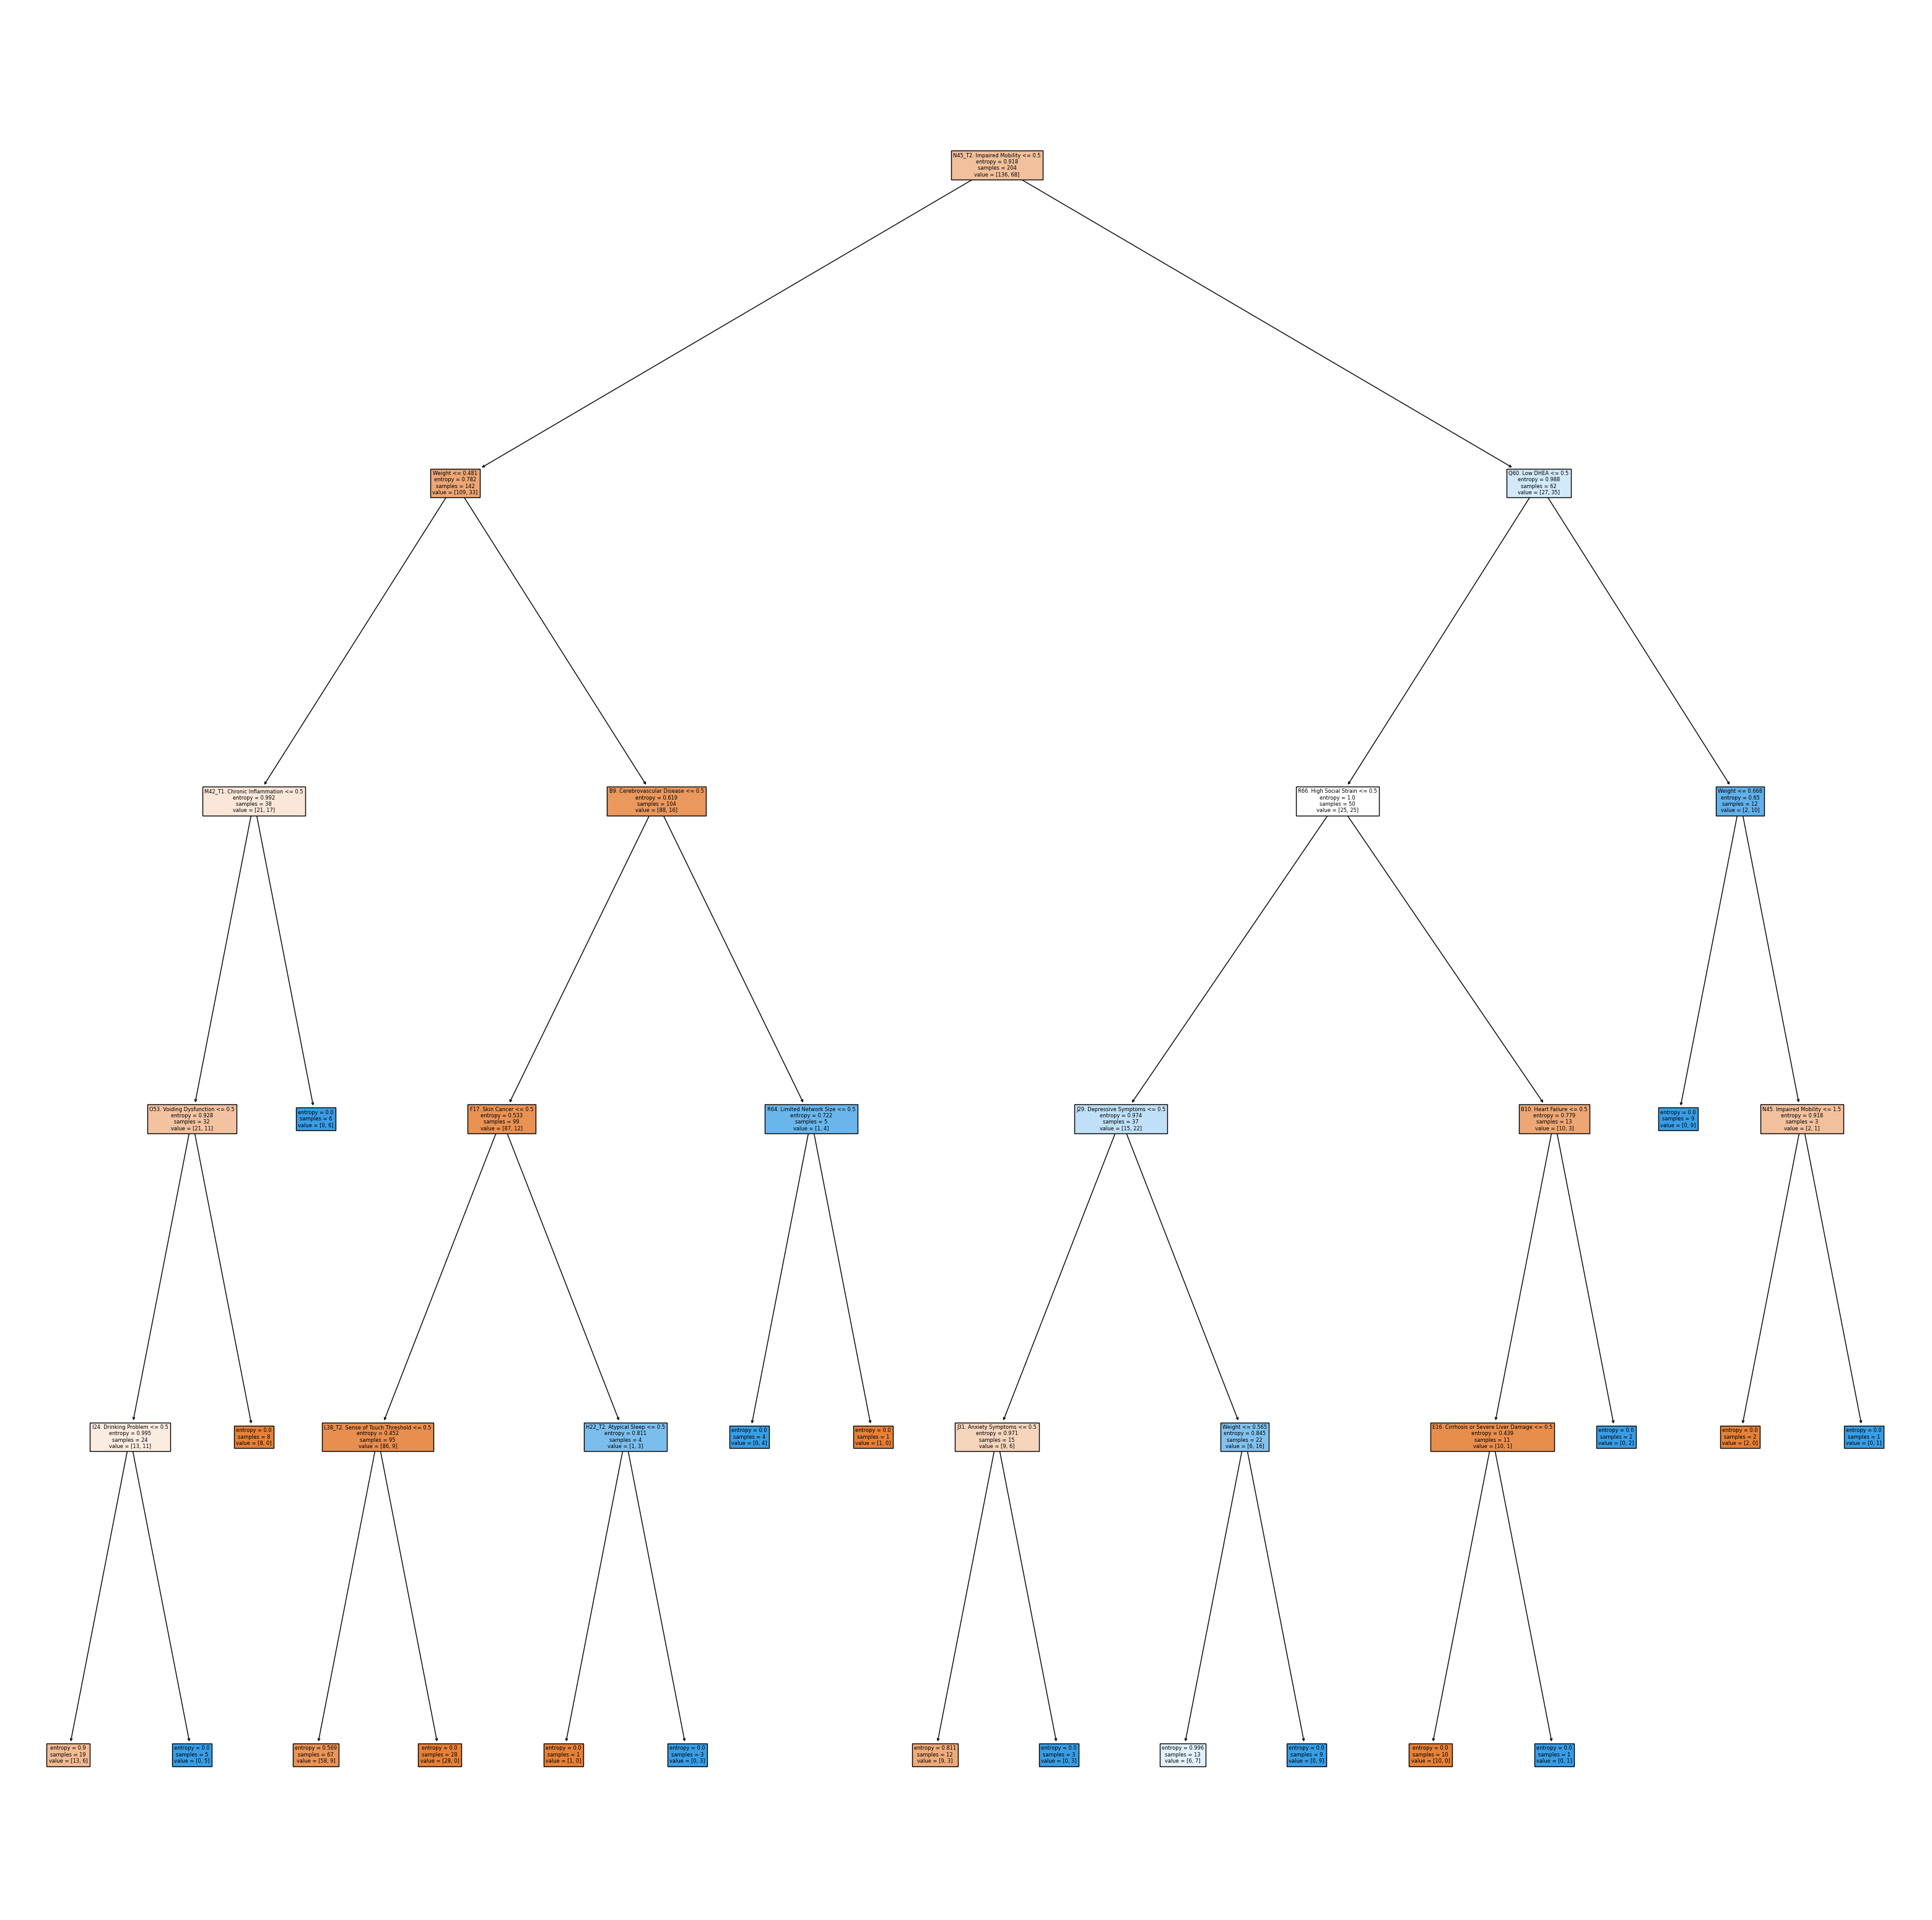

Performence on train set 0.8823529411764706
Performence on test set 0.7843137254901961
              precision    recall  f1-score   support

         0.0       0.81      0.88      0.85        34
         1.0       0.71      0.59      0.65        17

    accuracy                           0.78        51
   macro avg       0.76      0.74      0.75        51
weighted avg       0.78      0.78      0.78        51



In [60]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["race/ethnicity recode (4 categories)"] == 3]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.008)
DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))

44


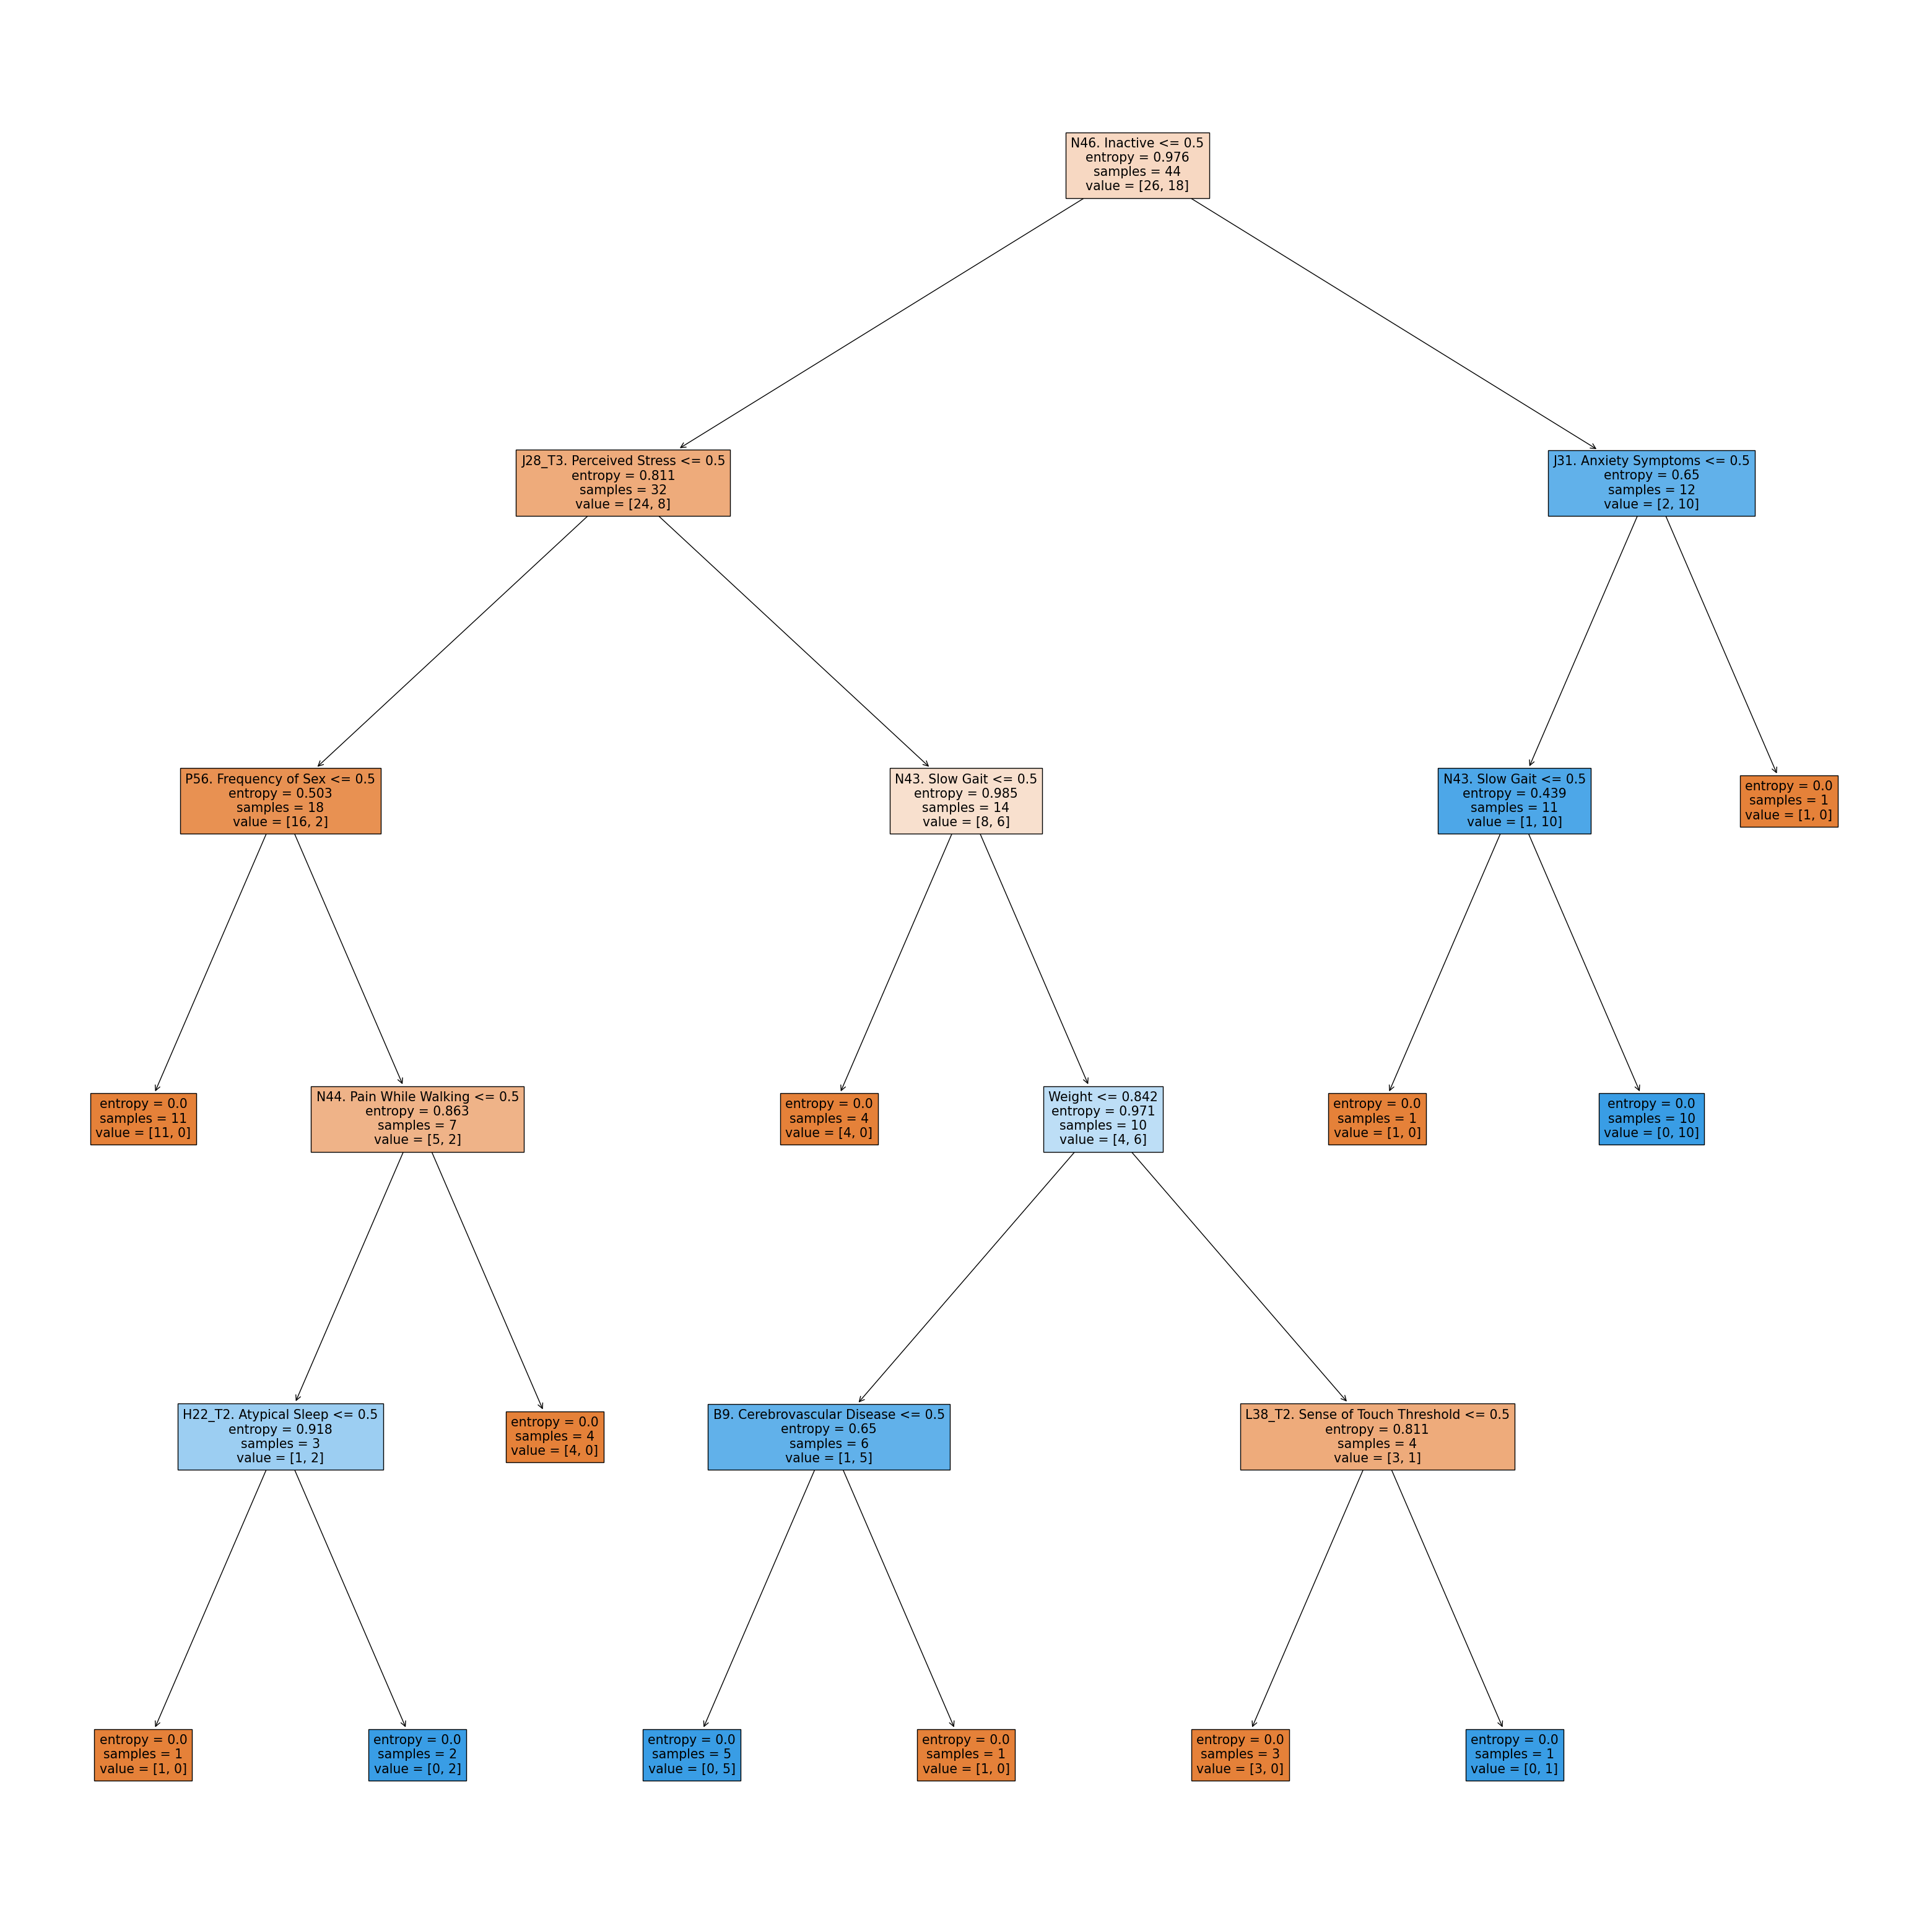

Performence on train set 1.0
Performence on test set 0.5454545454545454
              precision    recall  f1-score   support

         0.0       0.56      0.83      0.67         6
         1.0       0.50      0.20      0.29         5

    accuracy                           0.55        11
   macro avg       0.53      0.52      0.48        11
weighted avg       0.53      0.55      0.49        11



In [61]:
data_nona = data_filled.copy()
seed = 42
data_nona = data_nona[data_nona["race/ethnicity recode (4 categories)"] == 4]
data_nona.drop(columns=[
    "gender of respondent",
    "age of respondent (calculated in CAPI from dob)",
    "age recode (3 categories)",
    "education recode (4 categories)",
    "race/ethnicity recode (4 categories)",
], inplace=True)

data_x = data_nona.drop(columns=["Label"])  #, "Weight"
data_y = data_nona['Label']

ftr_names = list(data_x.columns)

#data_x.replace(to_replace=np.NaN, value=0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y)
# 0.25 x 0.8 = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v, test_size=0.25, random_state=42)

# Gender==2 female

data_y_m = data_y
data_x_m = data_x

# Then split into 60% training, 20% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data_x_m, data_y_m,
                                                    test_size=0.2,
                                                    random_state=42, stratify=data_y_m)

print(len(X_train))
ftr_names = list(data_x_m.columns)

DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=5,
                                     min_impurity_decrease=0.008)
DT_clf.fit(X_train, y_train)

plt.figure(figsize=(40, 40))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test), columns=["Label"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))